# <b>Preprocessing count matrices with SoupX and scDblFinder</b>
### SoupX is used to remove ambient RNA. scDblFinder is used to find and remove doublets
### This notebook was inspired by: https://github.com/mousepixels/sanbomics_scripts/blob/main/soupX/soupX_python_test.ipynb

In [1]:
### Import packages
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
### List of the folder names that contain the filtered feature matrices.
sample_ids = ['P_CTRL_8W_M_01', 'P_CTRL_8W_M_02', 'P_CTRL_8W_M_03', 'P_HF_8W_M_01', 'P_HF_8W_M_02', 'P_HF_8W_M_03',\
              'P_CTRL_24W_M_01', 'P_CTRL_24W_M_02', 'P_CTRL_24W_M_03', 'P_HF_24W_M_01', 'P_HF_24W_M_02', 'P_HF_24W_M_03',\
              'P_CTRL_24W_F_02', 'P_CTRL_8W_F_01', 'P_CTRL_8W_F_03', 'P_HF_24W_F_02', 'P_HF_24W_F_04', 'P_HF_8W_F_02', \
              'P_CTRL_24W_F_01', 'P_CTRL_24W_F_03', 'P_CTRL_8W_F_02', 'P_HF_24W_F_01', 'P_HF_24W_F_03', 'P_HF_8W_F_01', \
              'P_HF_8W_F_03']

In [3]:
### Preprocessing samples with scanpy.
def is_outlier(adata, metric, nmads):
    M = adata.obs[metric]
    return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    

def pp(sample_id):
    print(sample_id)
    adata = sc.read_10x_mtx('../data/' + sample_id + '/filtered_feature_bc_matrix')
    adata.obs['sample_id'] = sample_id
    
    
    #calculate QC metrics
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("Mt-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(P)]"))

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], 
                               inplace=True, percent_top=[20], log1p=True)
    
    #Plot QC metrics
    p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
    p2 = sc.pl.violin(adata, "pct_counts_mt")
    p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    
    #filter outliers
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )

    adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > 5)

    print(adata.obs.outlier.value_counts())
    print(adata.obs.mt_outlier.value_counts())
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    p2 = sc.pl.violin(adata, "pct_counts_mt")
    
    return adata

In [4]:
### This is necessary to run R code in Python
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [5]:
### Getting Leiden clusters
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    return adata_pp.obs['soupx_groups']
    
    

def prepare_broth(adata):
    # Make into individual components to pass to R
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    #get raw data
    sample_id = adata.obs.iloc[0]['sample_id']
    raw = sc.read_10x_mtx('../data/' + sample_id + '/raw_feature_bc_matrix/').X.T
    
    #get leiden clusters
    soupx_groups = get_soupx_group(adata)

    return data, raw, genes, cells, soupx_groups

In [6]:
%%R

library(SoupX)

make_soup <- function(data, raw, genes, cells, soupx_groups){
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells
    # ensure correct sparse format for table of counts and table of droplets
    data <- as(data, "sparseMatrix")
    raw <- as(raw, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(raw, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    sc  = autoEstCont(sc, doPlot=FALSE, forceAccept=TRUE)
    # Infer corrected table of counts and round to integer
    out = adjustCounts(sc, roundToInt = TRUE)
    
    return(out)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


In [7]:
def cook_soup(adata):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata)

    # Execute the R code and get the corrected counts
    %R -i data -i raw -i genes -i cells -i soupx_groups -o out out = make_soup(data, raw, genes, cells, soupx_groups)


    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]
    
    return adata

P_CTRL_8W_M_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


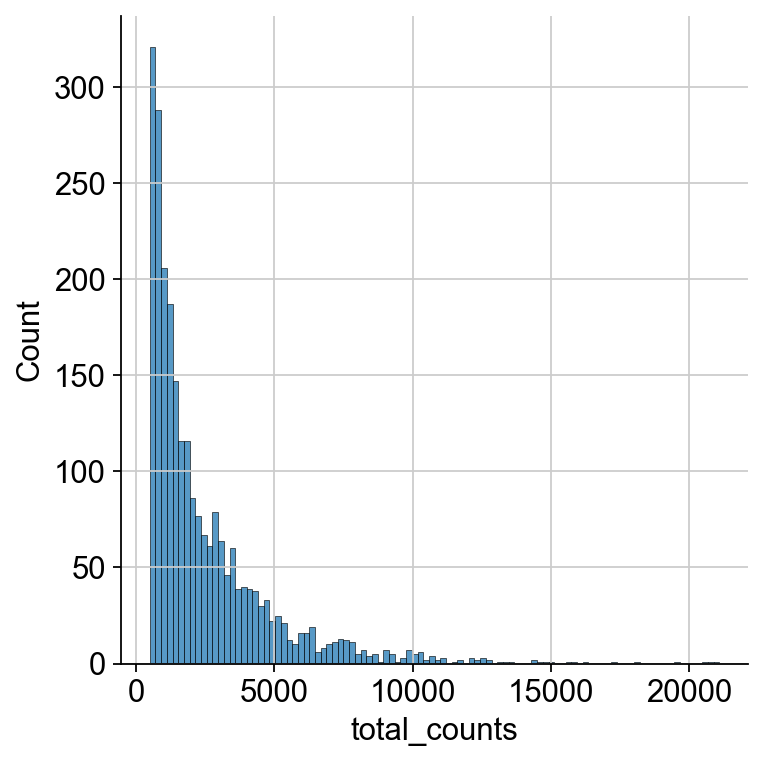

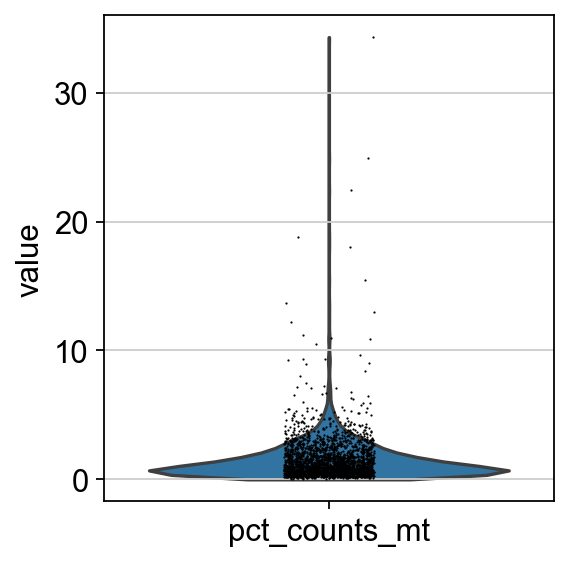

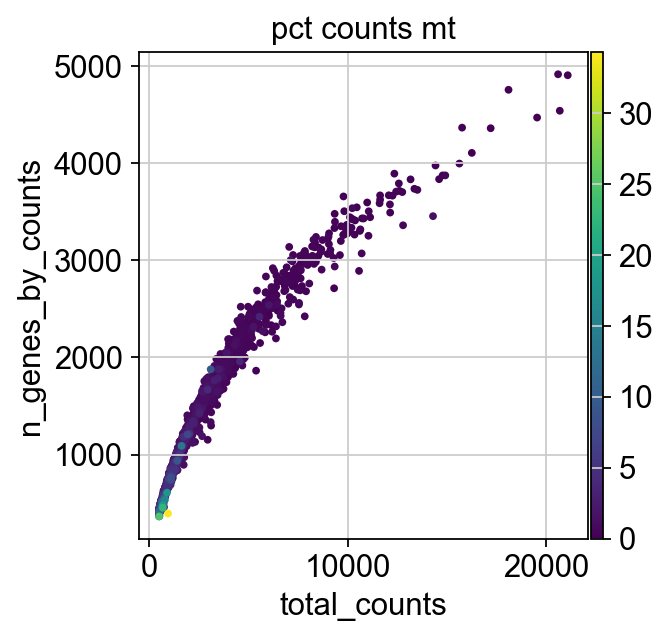

False    2394
True       55
Name: outlier, dtype: int64
False    2393
True       56
Name: mt_outlier, dtype: int64
Total number of cells: 2449
Number of cells after filtering of low quality cells: 2361


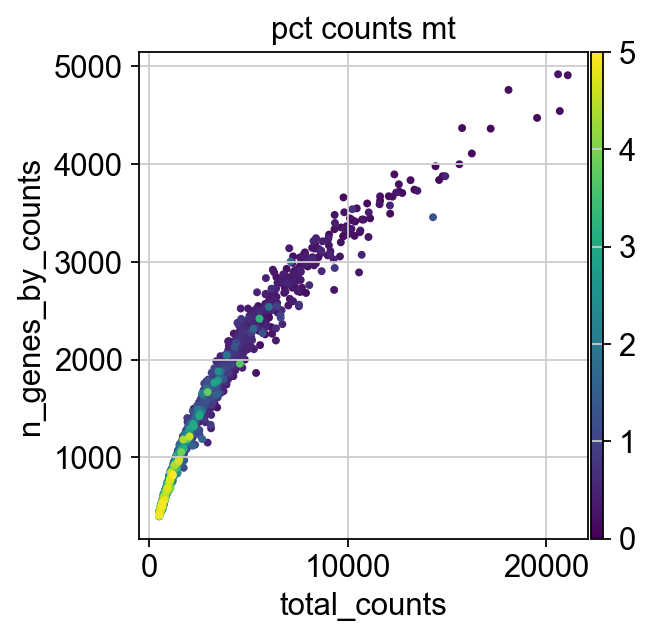

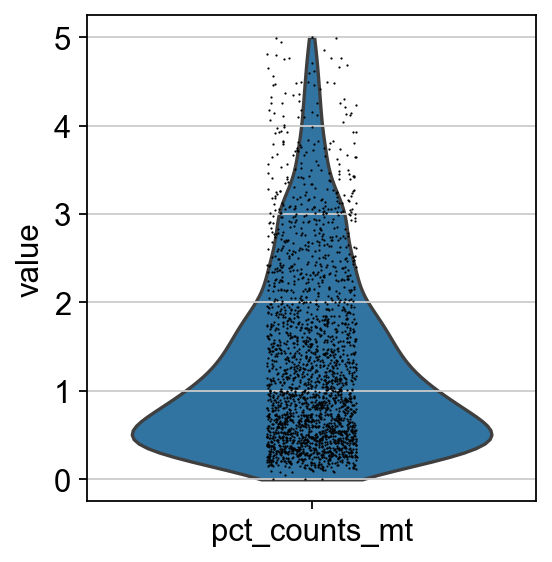

P_CTRL_8W_M_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


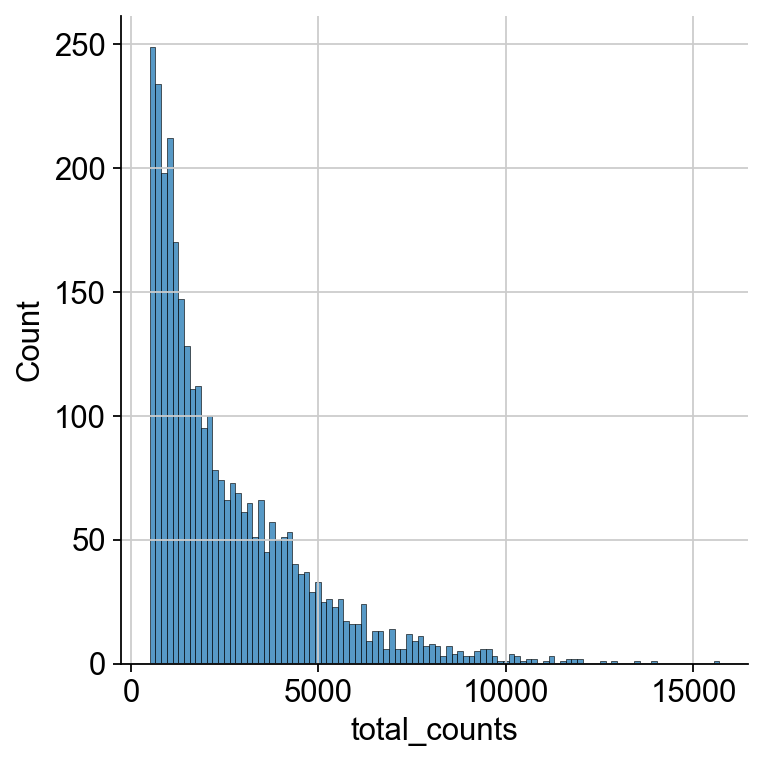

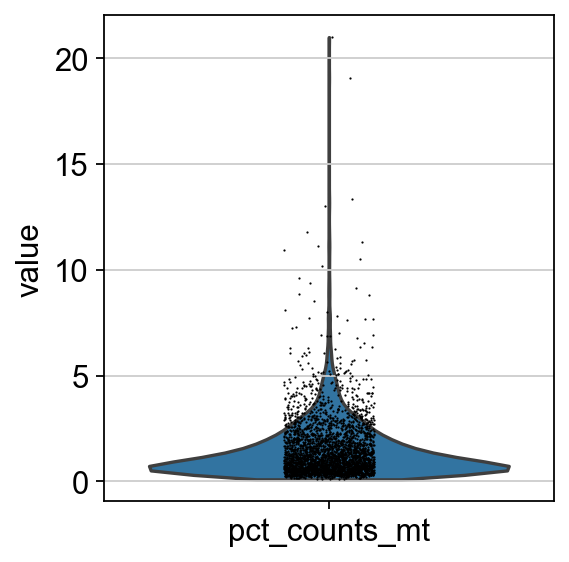

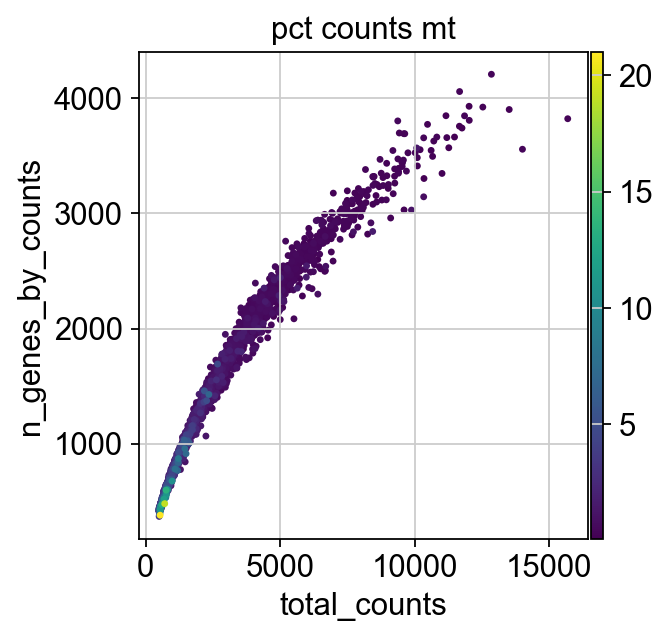

False    3091
True       68
Name: outlier, dtype: int64
False    3085
True       74
Name: mt_outlier, dtype: int64
Total number of cells: 3159
Number of cells after filtering of low quality cells: 3049


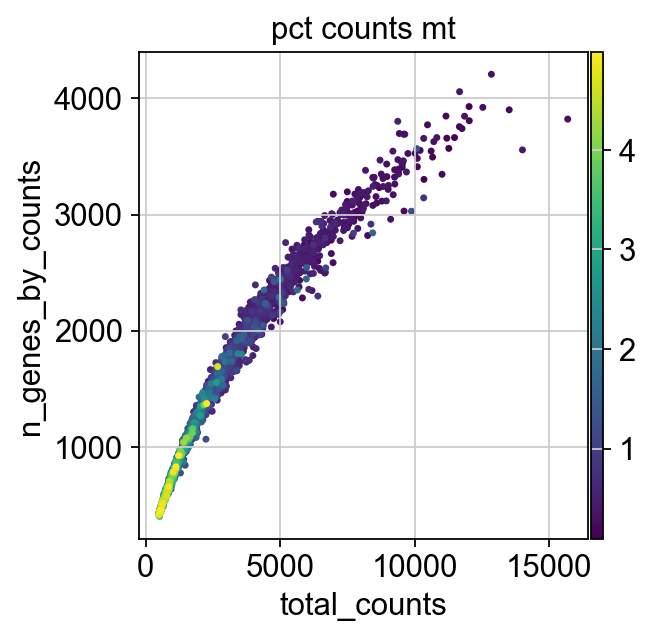

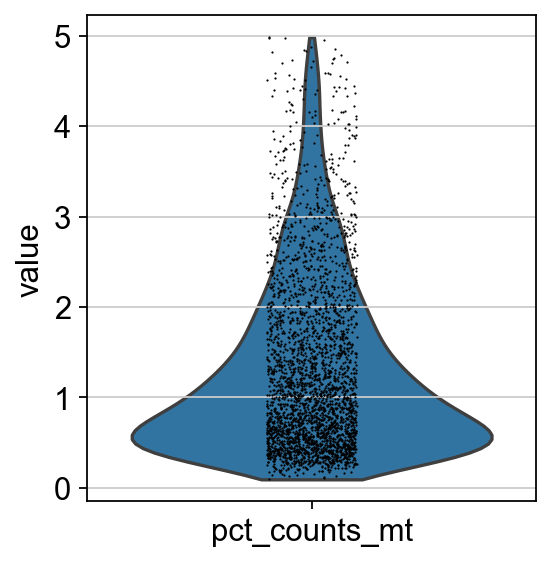

P_CTRL_8W_M_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


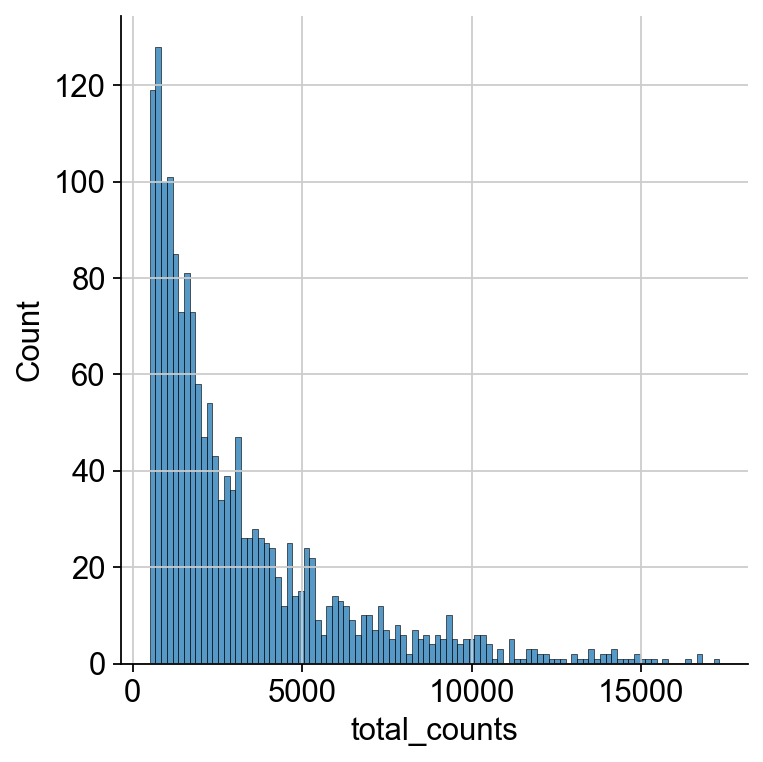

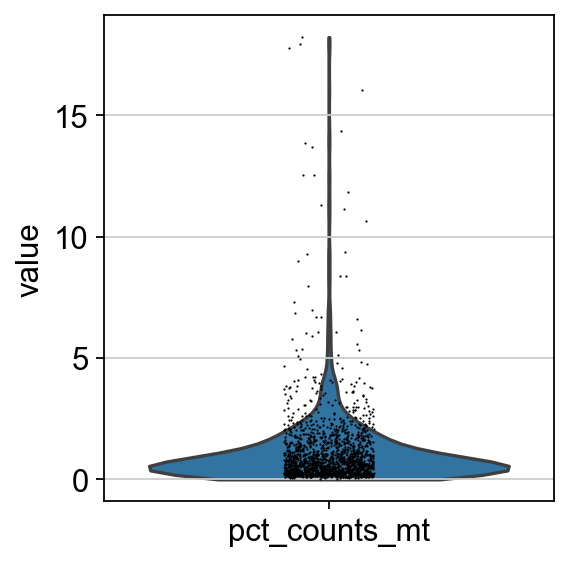

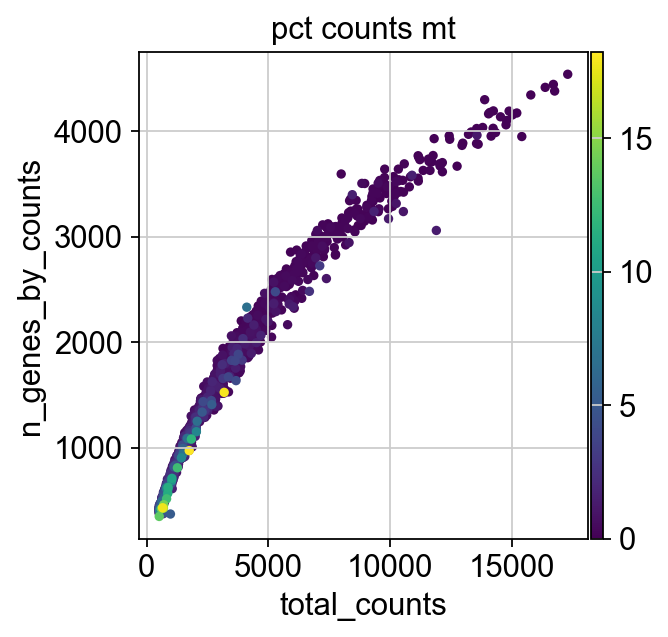

False    1649
True       32
Name: outlier, dtype: int64
False    1644
True       37
Name: mt_outlier, dtype: int64
Total number of cells: 1681
Number of cells after filtering of low quality cells: 1629


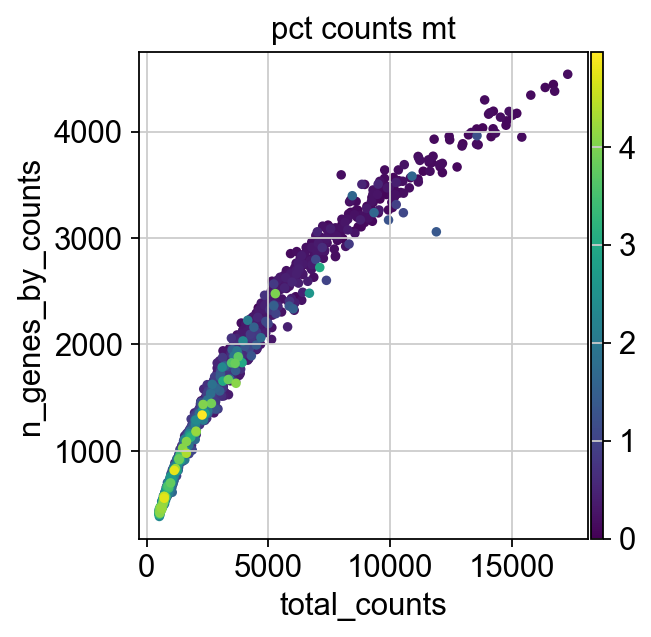

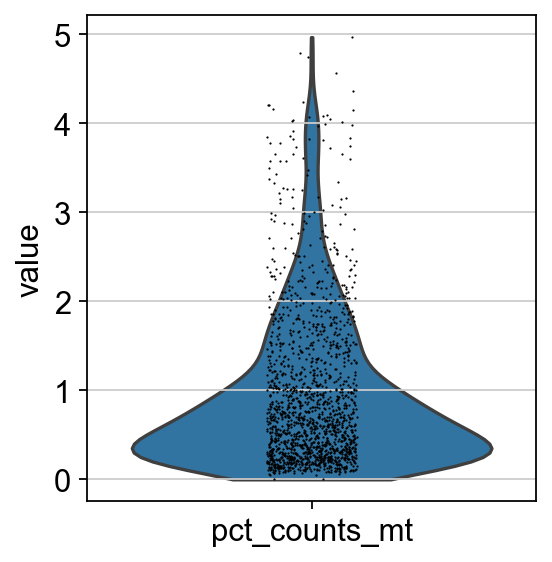

P_HF_8W_M_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


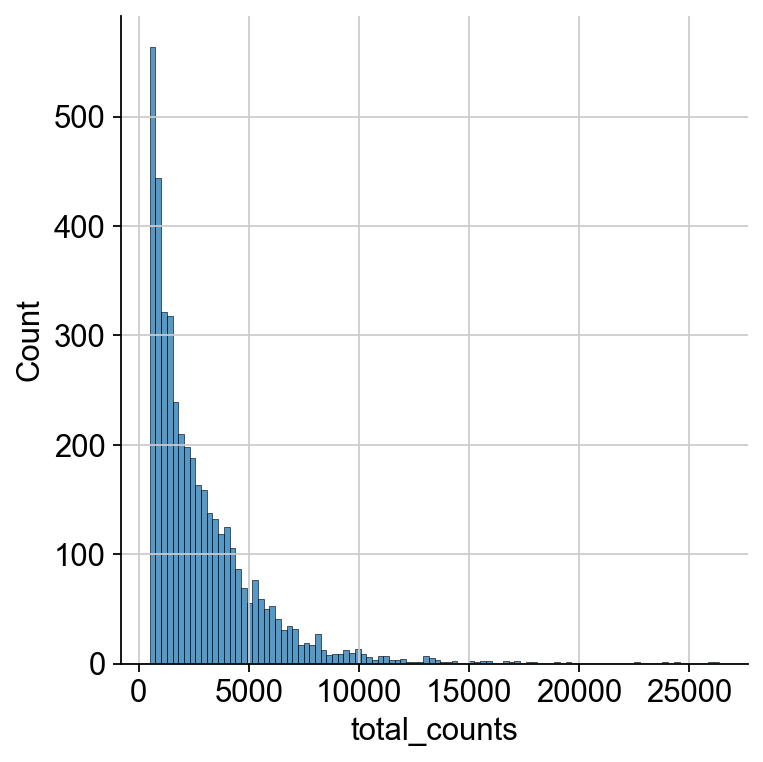

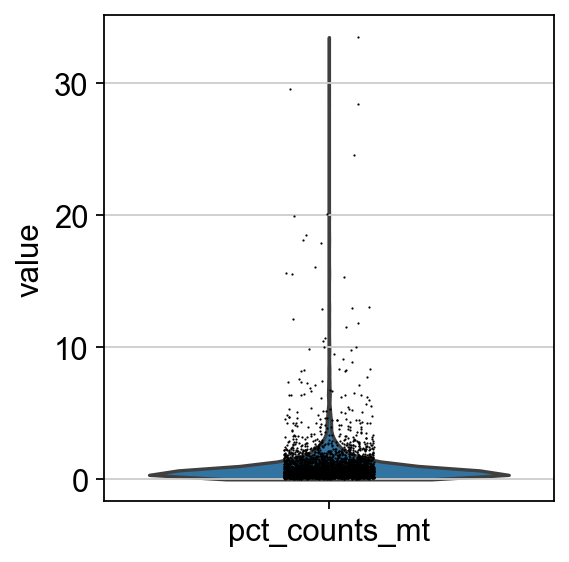

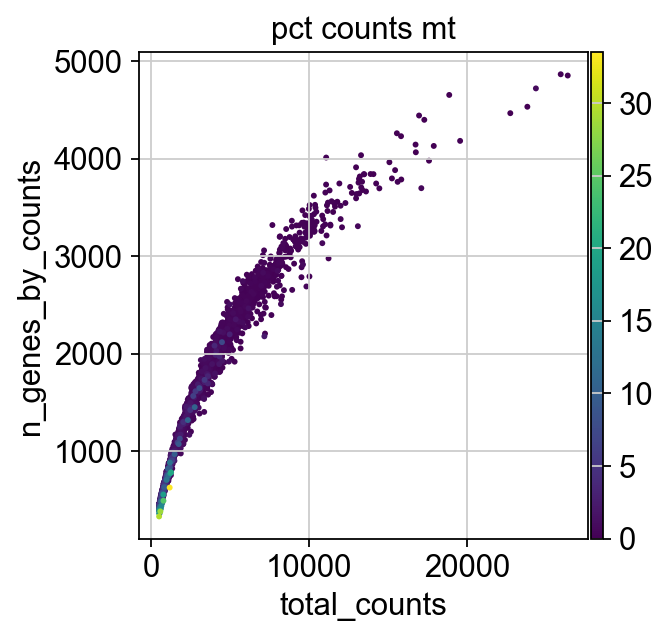

False    4145
True      102
Name: outlier, dtype: int64
False    4176
True       71
Name: mt_outlier, dtype: int64
Total number of cells: 4247
Number of cells after filtering of low quality cells: 4111


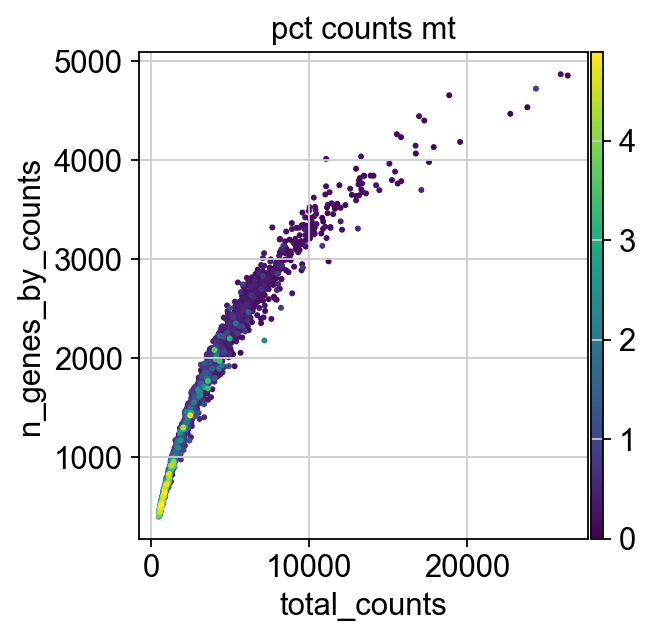

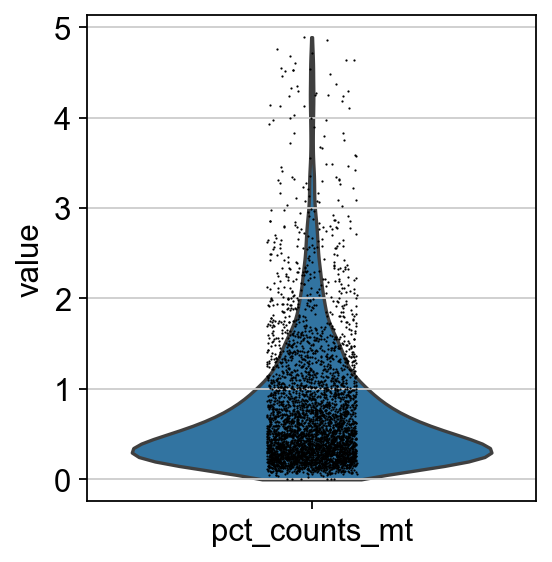

P_HF_8W_M_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


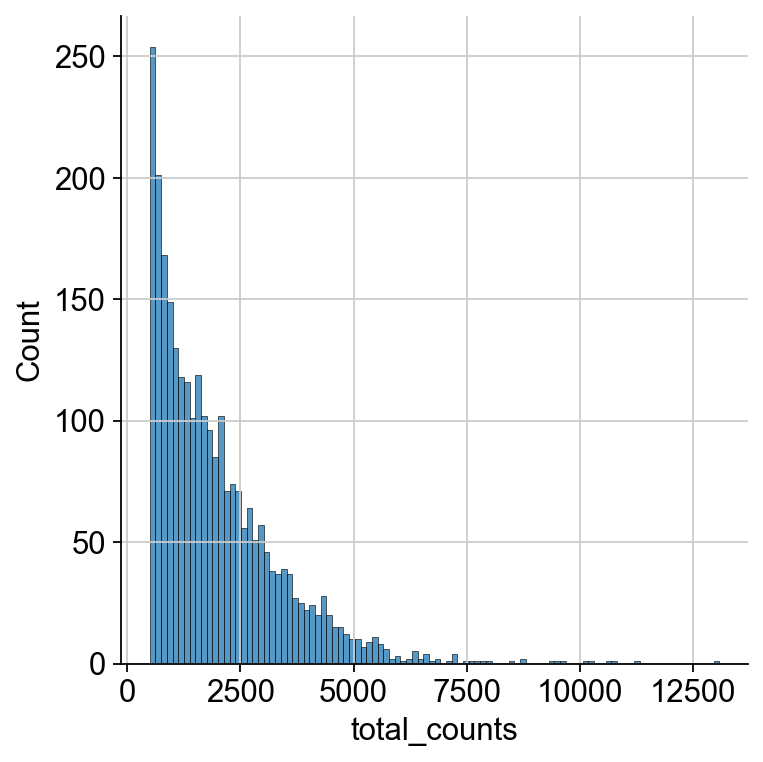

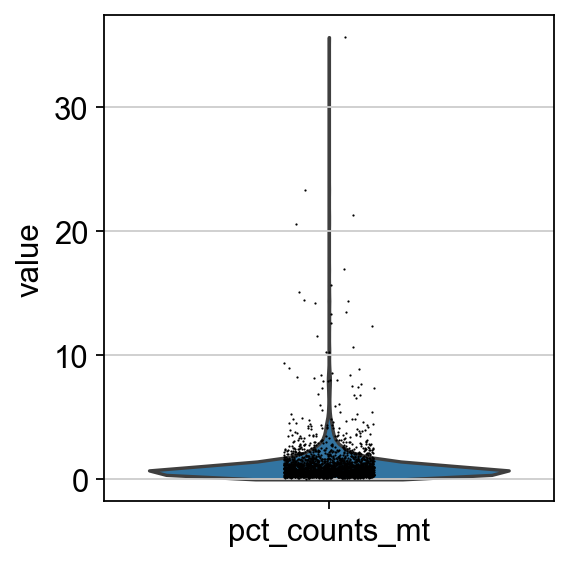

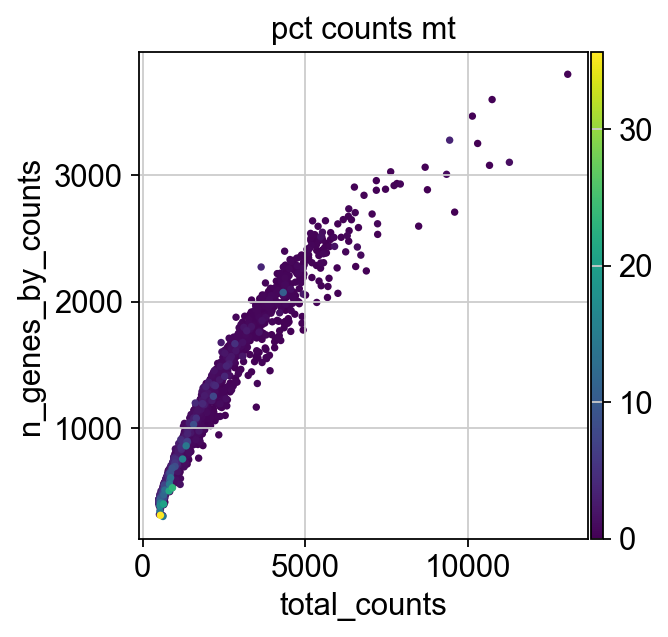

False    2458
True      237
Name: outlier, dtype: int64
False    2648
True       47
Name: mt_outlier, dtype: int64
Total number of cells: 2695
Number of cells after filtering of low quality cells: 2436


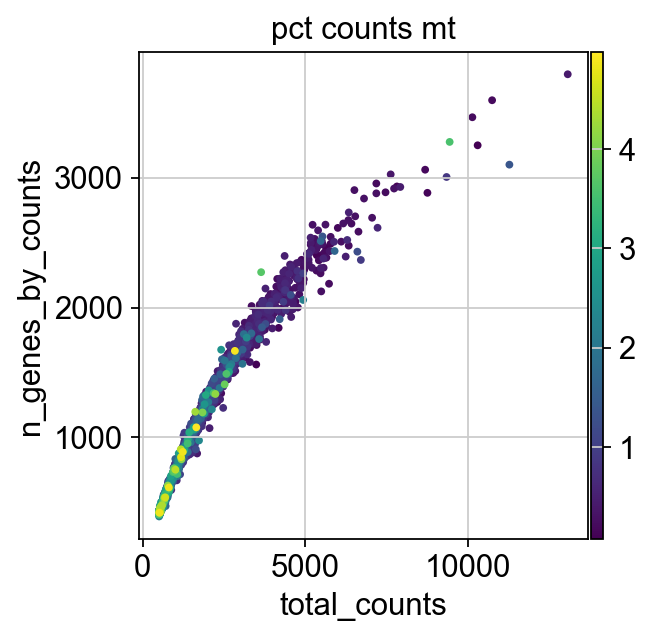

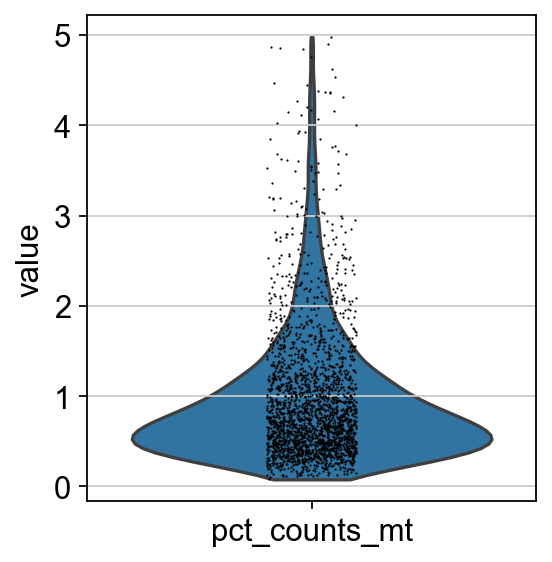

P_HF_8W_M_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


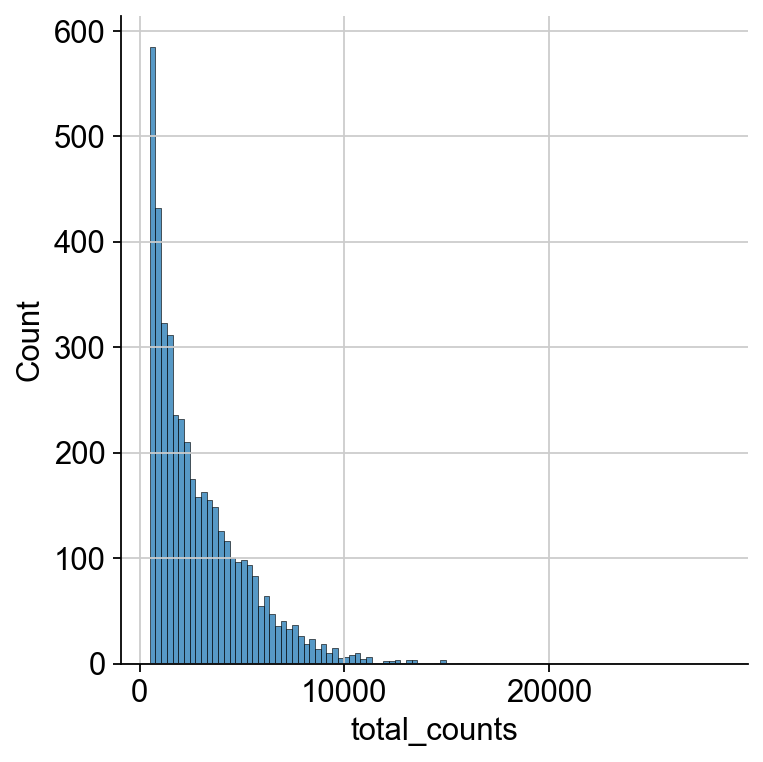

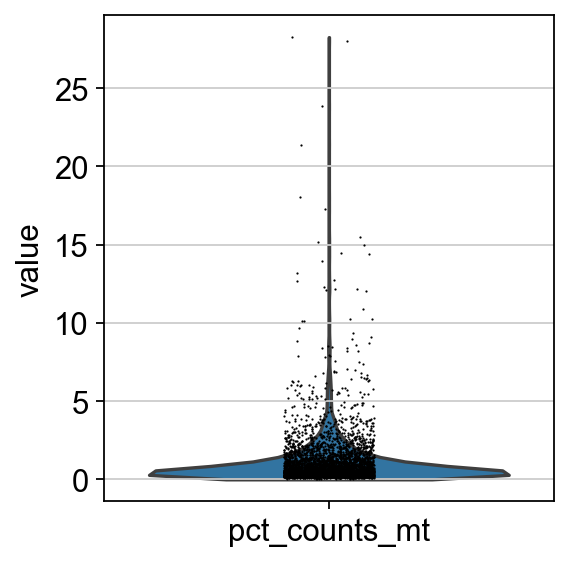

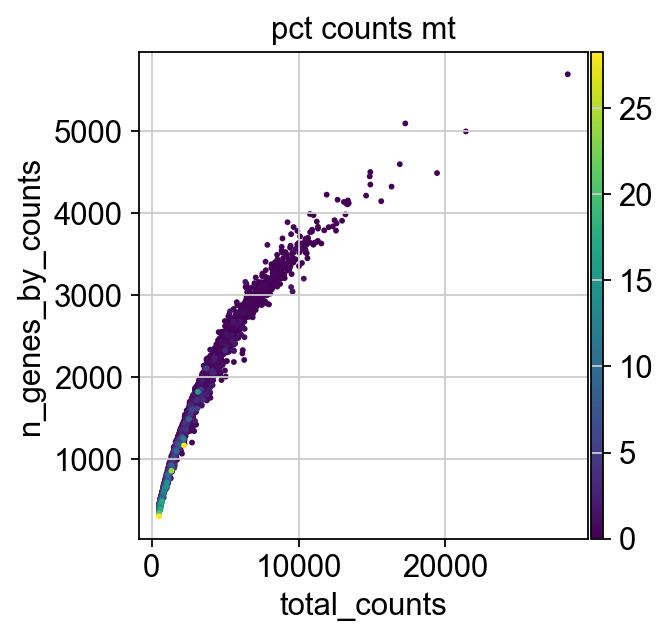

False    4209
True      136
Name: outlier, dtype: int64
False    4244
True      101
Name: mt_outlier, dtype: int64
Total number of cells: 4345
Number of cells after filtering of low quality cells: 4162


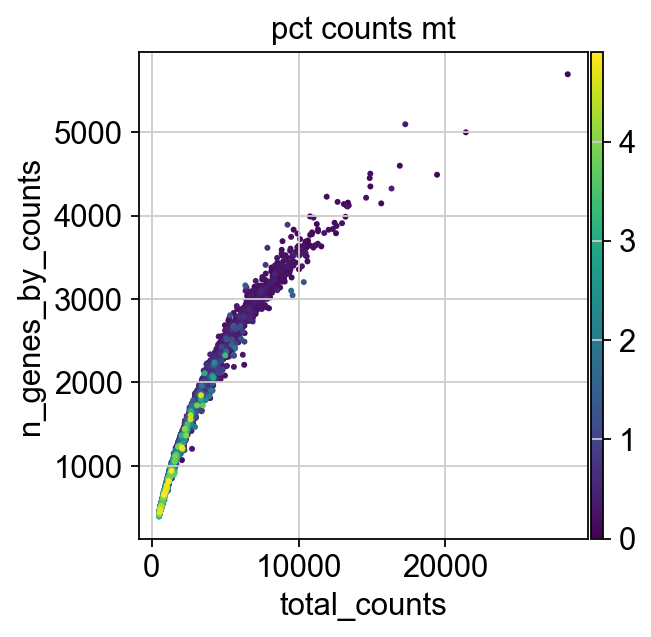

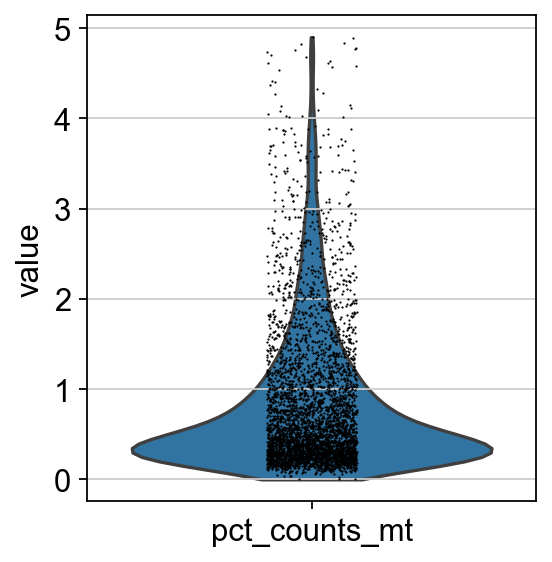

P_CTRL_24W_M_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


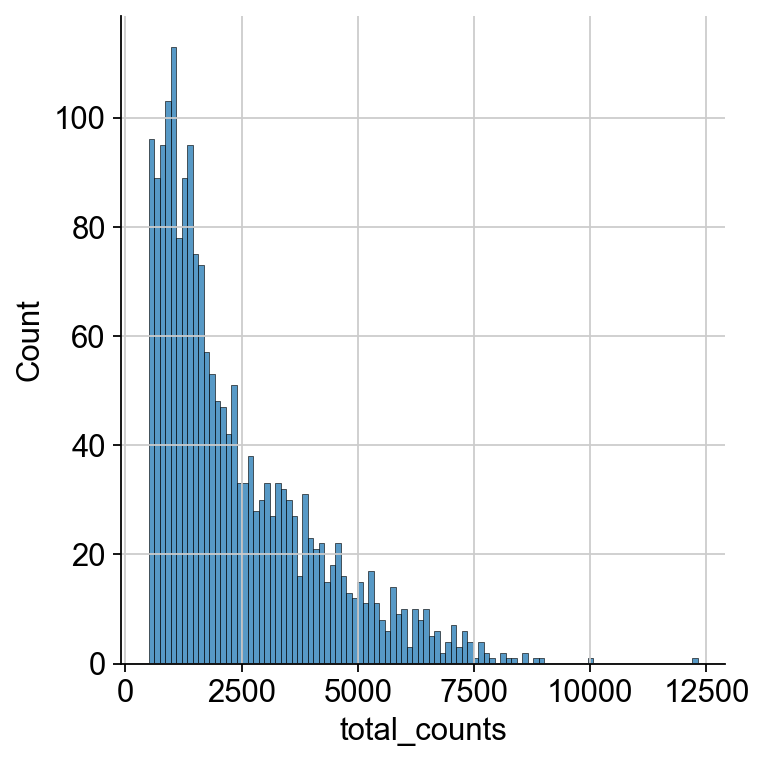

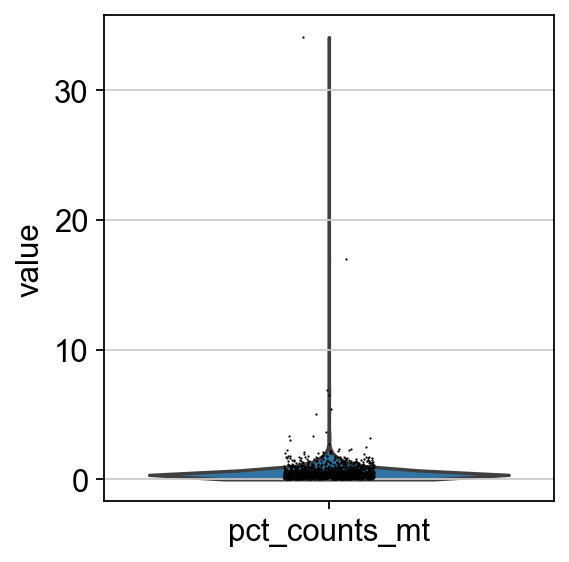

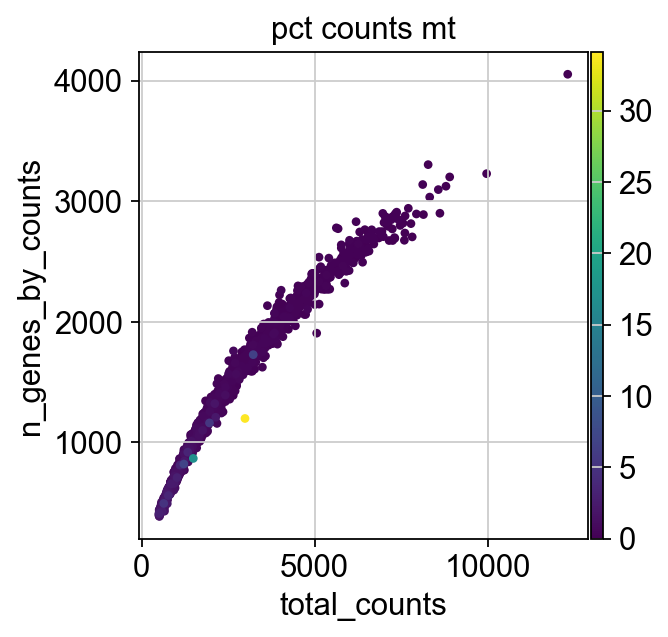

False    1885
True       59
Name: outlier, dtype: int64
False    1938
True        6
Name: mt_outlier, dtype: int64
Total number of cells: 1944
Number of cells after filtering of low quality cells: 1882


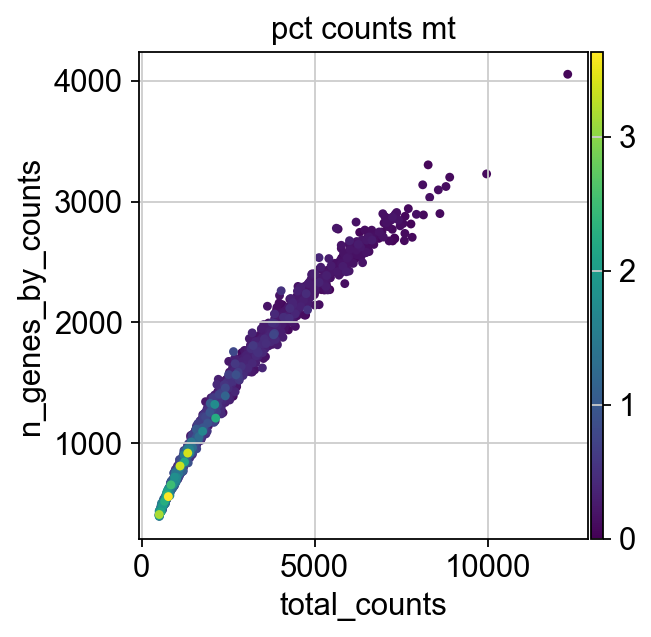

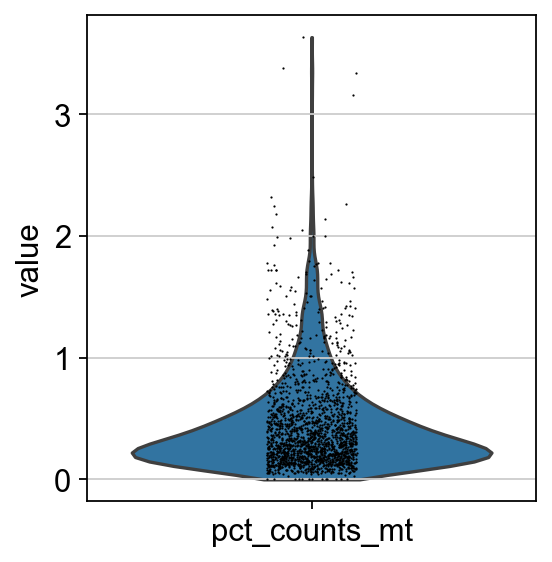

P_CTRL_24W_M_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


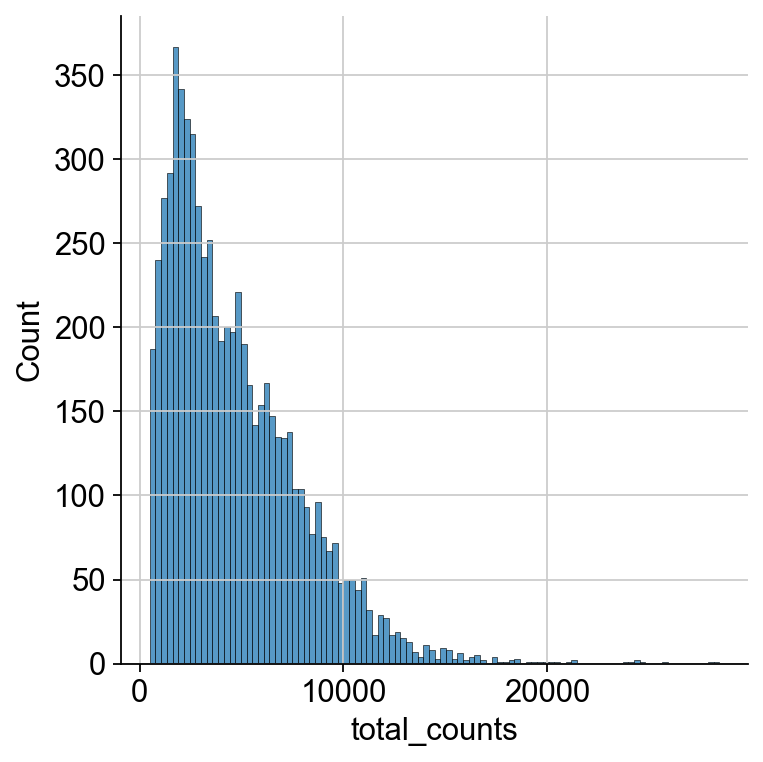

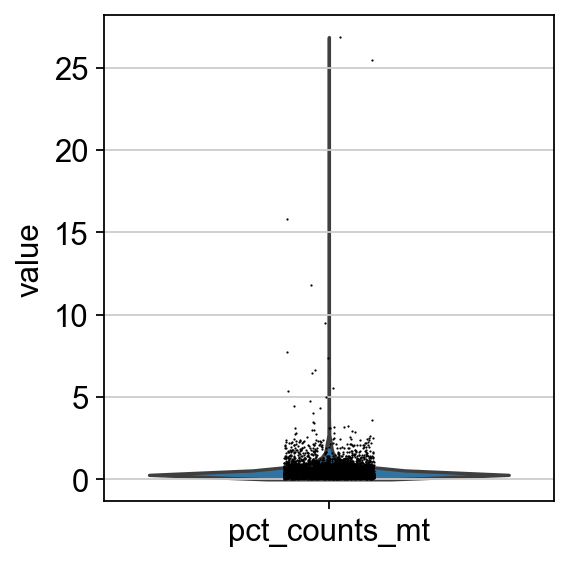

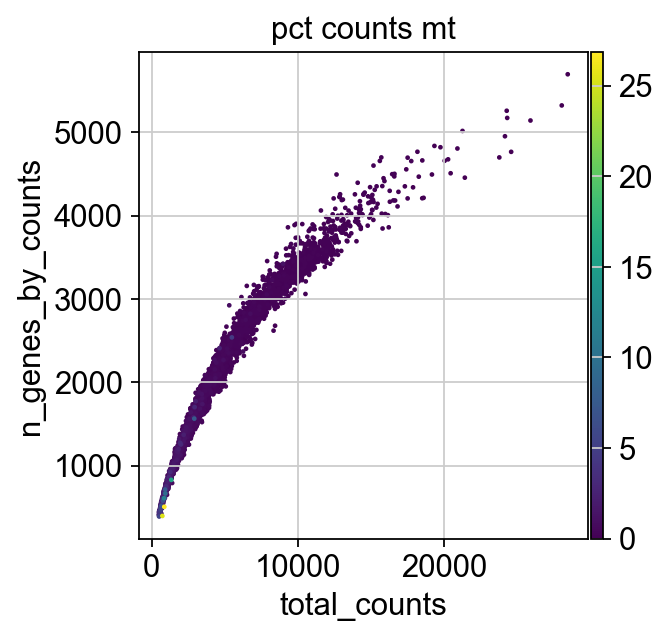

False    6506
True      194
Name: outlier, dtype: int64
False    6689
True       11
Name: mt_outlier, dtype: int64
Total number of cells: 6700
Number of cells after filtering of low quality cells: 6506


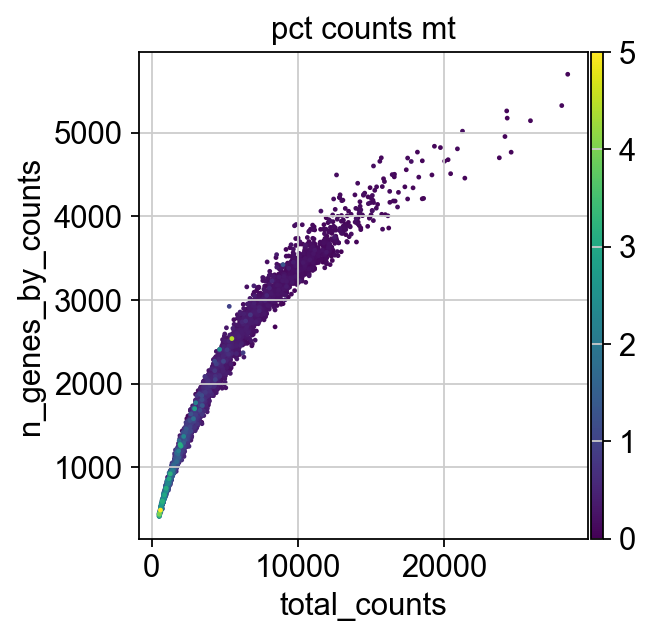

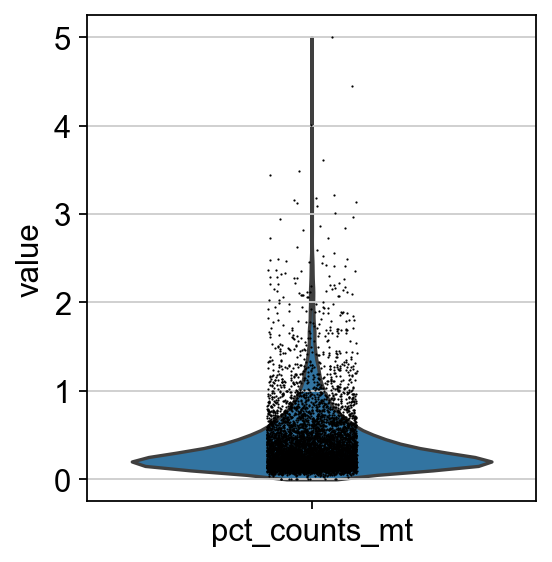

P_CTRL_24W_M_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


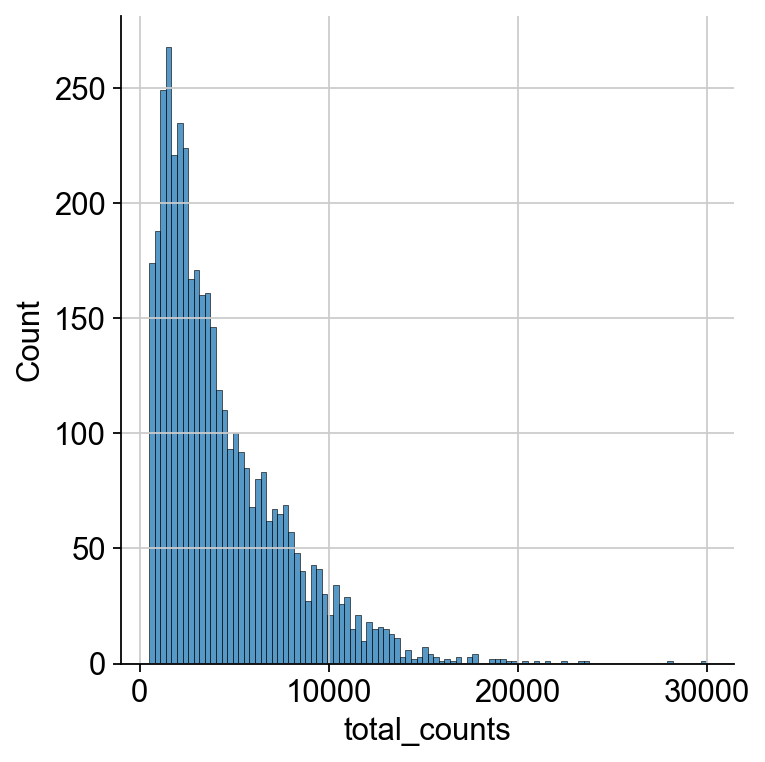

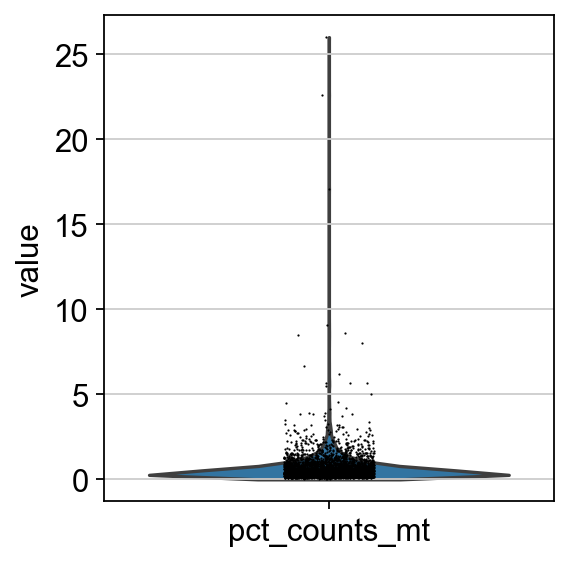

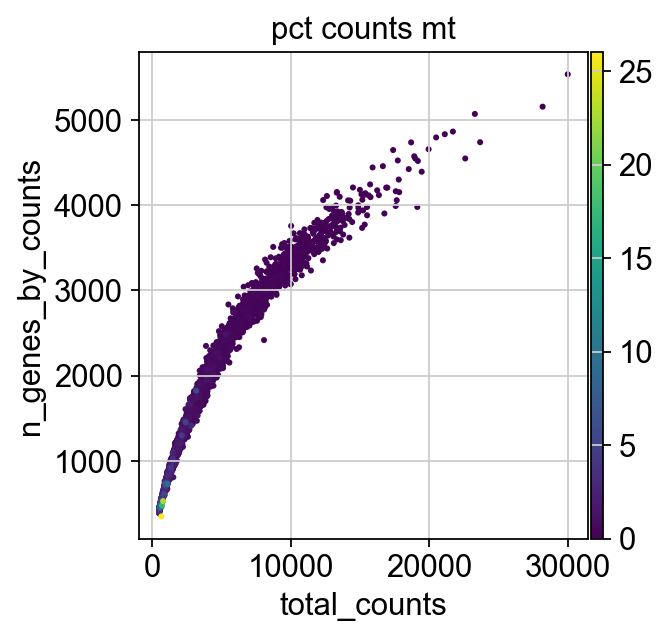

False    3942
True      103
Name: outlier, dtype: int64
False    4031
True       14
Name: mt_outlier, dtype: int64
Total number of cells: 4045
Number of cells after filtering of low quality cells: 3935


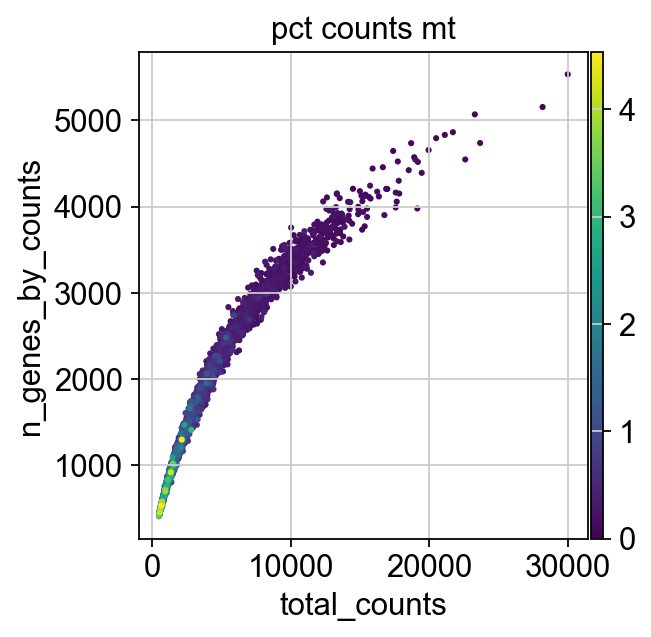

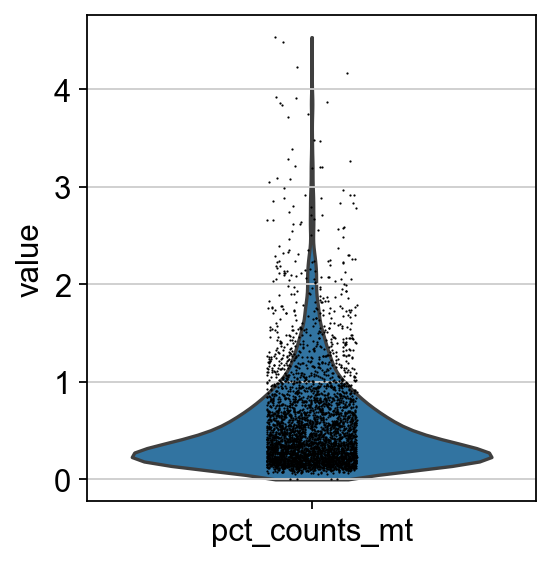

P_HF_24W_M_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


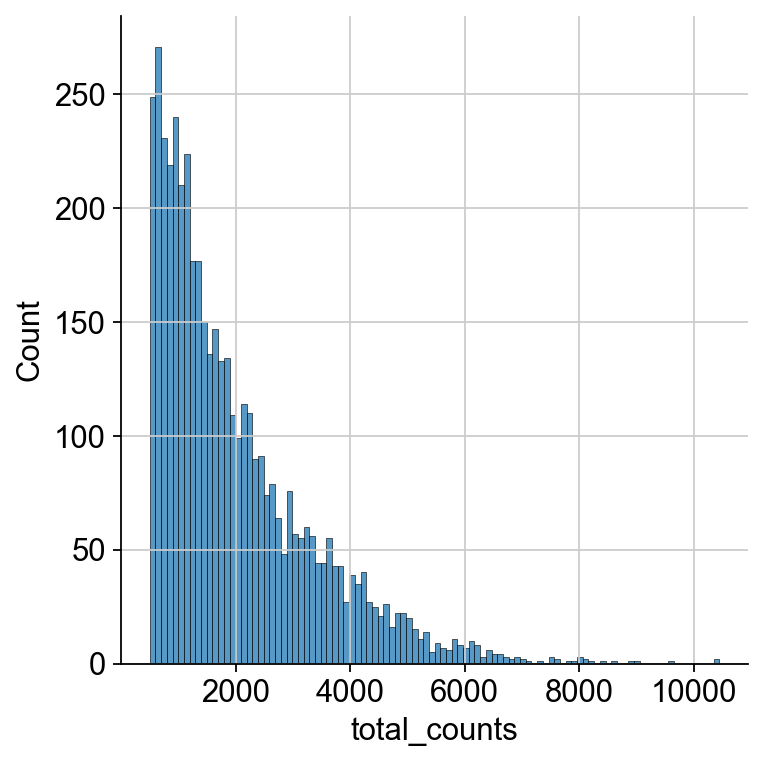

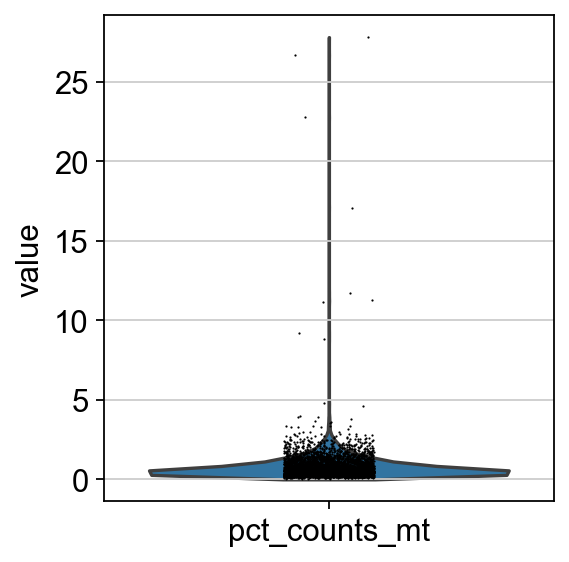

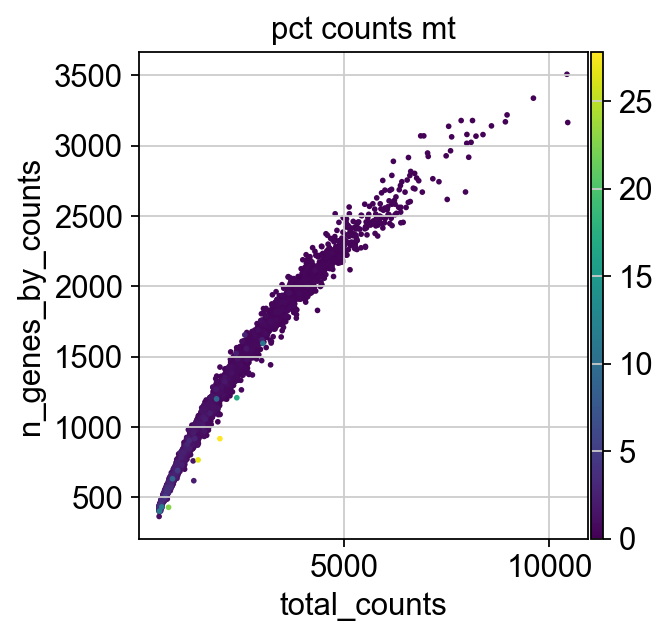

False    4520
True       69
Name: outlier, dtype: int64
False    4580
True        9
Name: mt_outlier, dtype: int64
Total number of cells: 4589
Number of cells after filtering of low quality cells: 4519


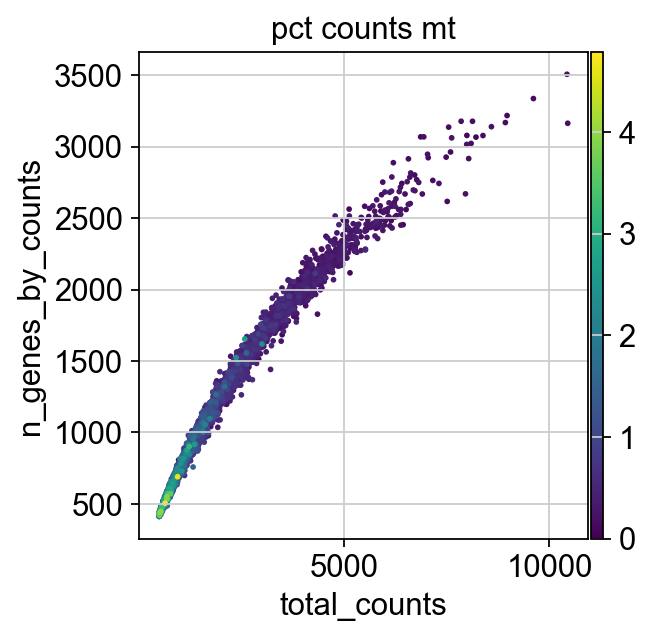

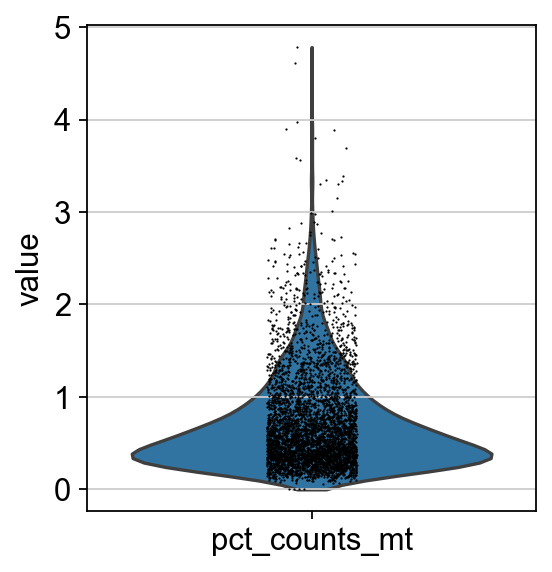

P_HF_24W_M_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


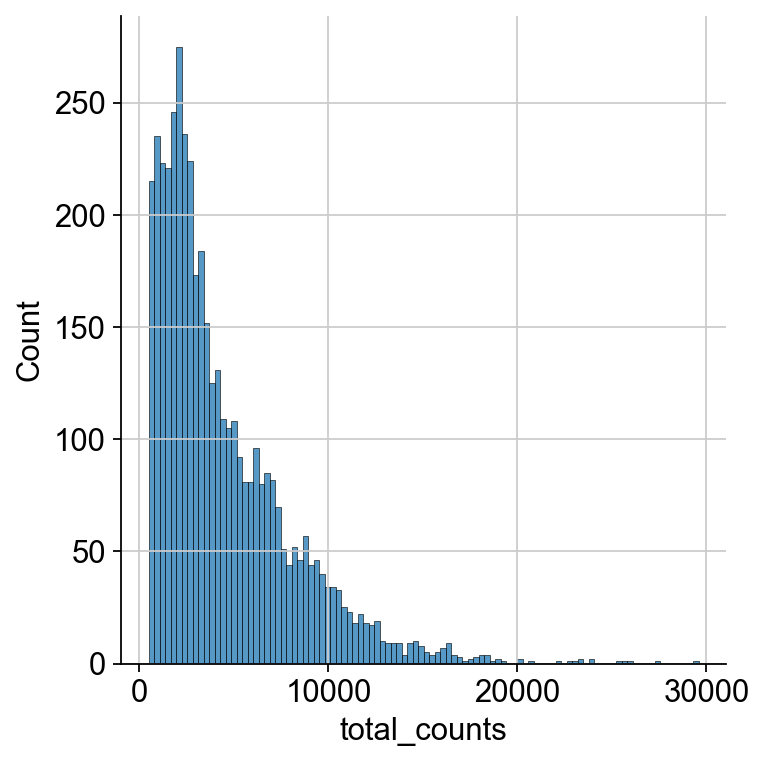

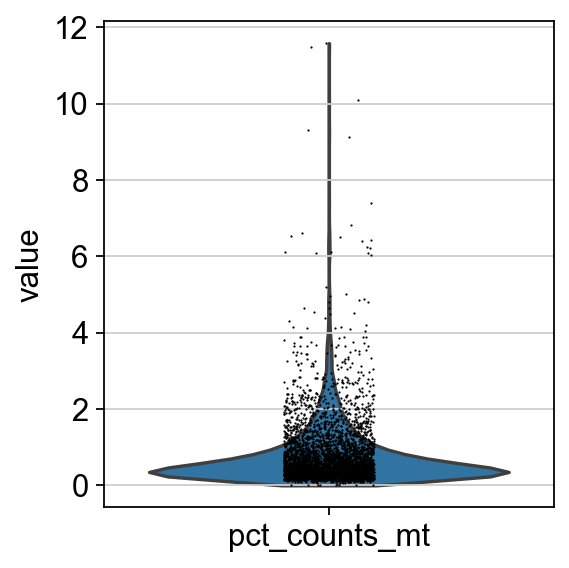

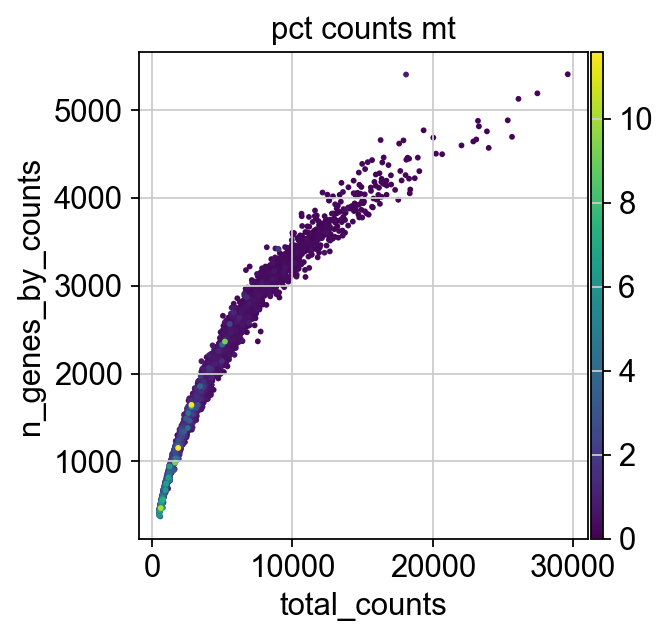

False    4251
True      139
Name: outlier, dtype: int64
False    4369
True       21
Name: mt_outlier, dtype: int64
Total number of cells: 4390
Number of cells after filtering of low quality cells: 4244


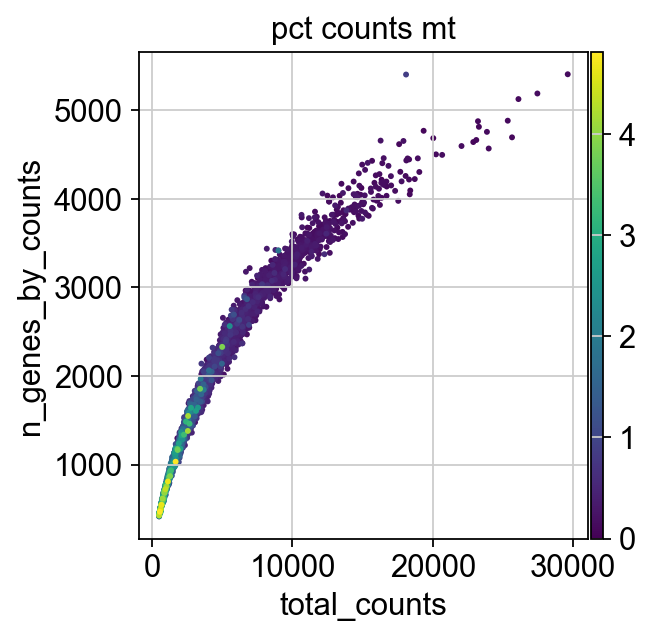

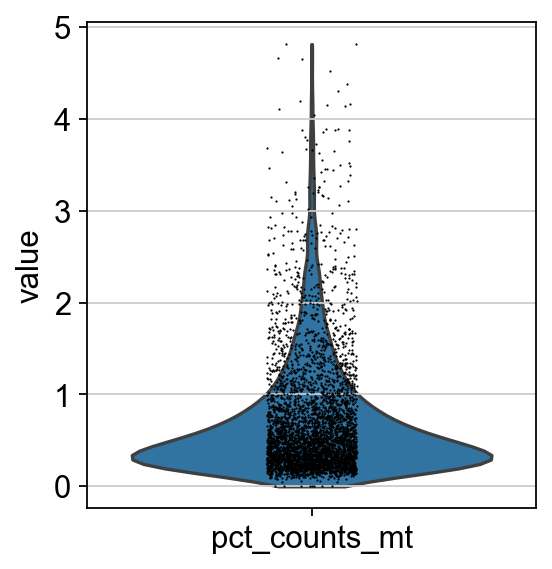

P_HF_24W_M_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


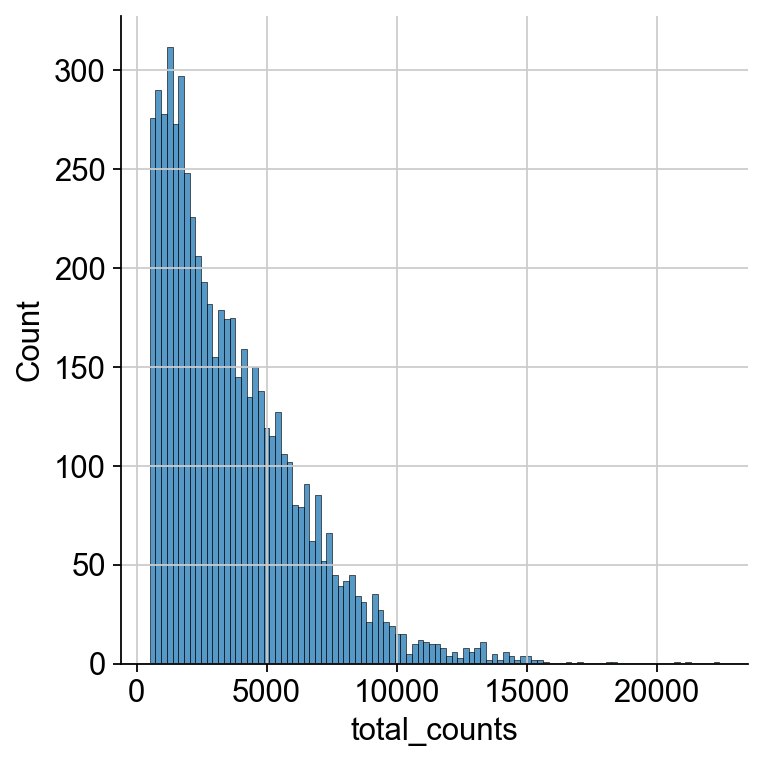

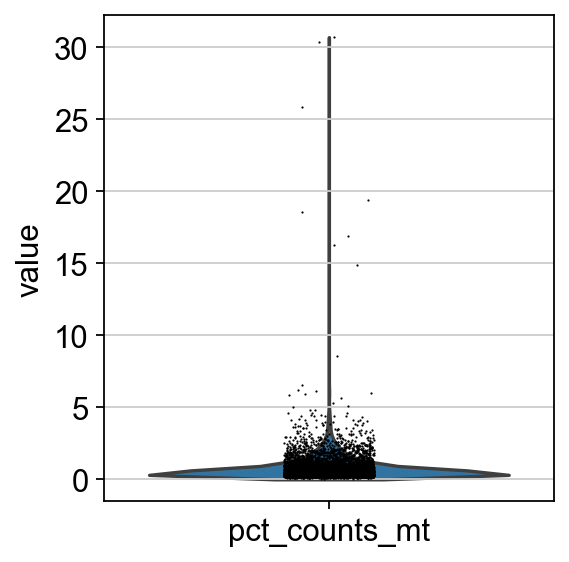

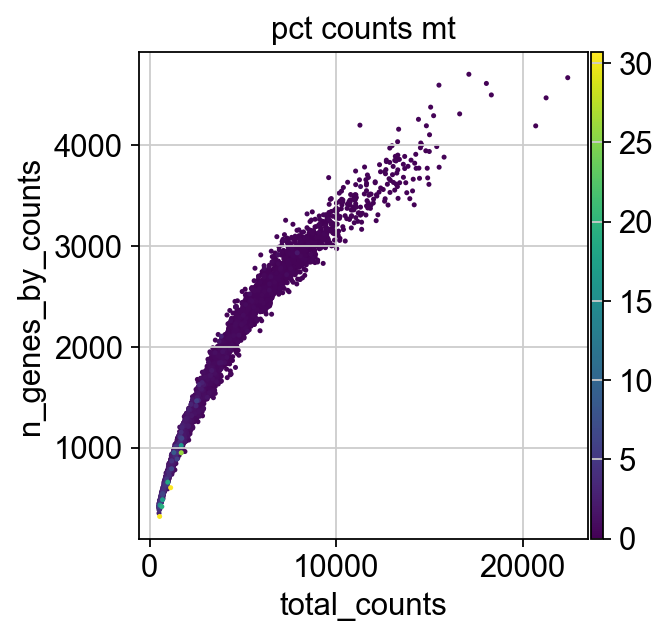

False    5702
True      115
Name: outlier, dtype: int64
False    5799
True       18
Name: mt_outlier, dtype: int64
Total number of cells: 5817
Number of cells after filtering of low quality cells: 5696


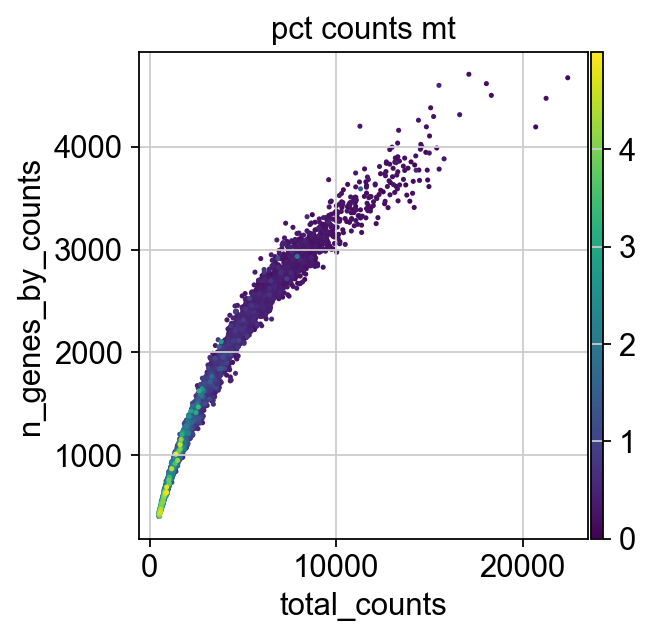

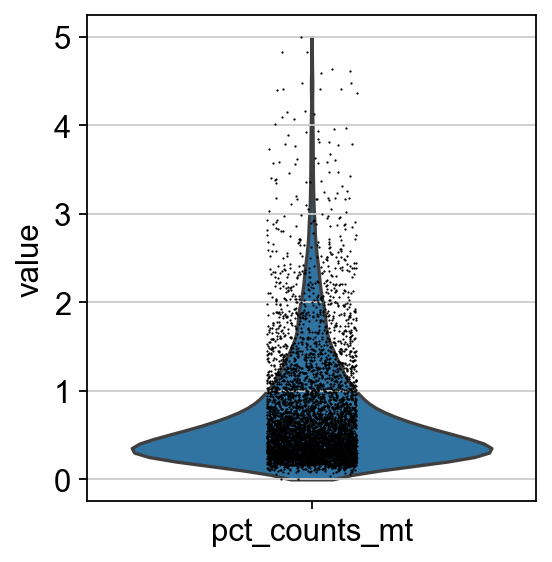

P_CTRL_24W_F_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


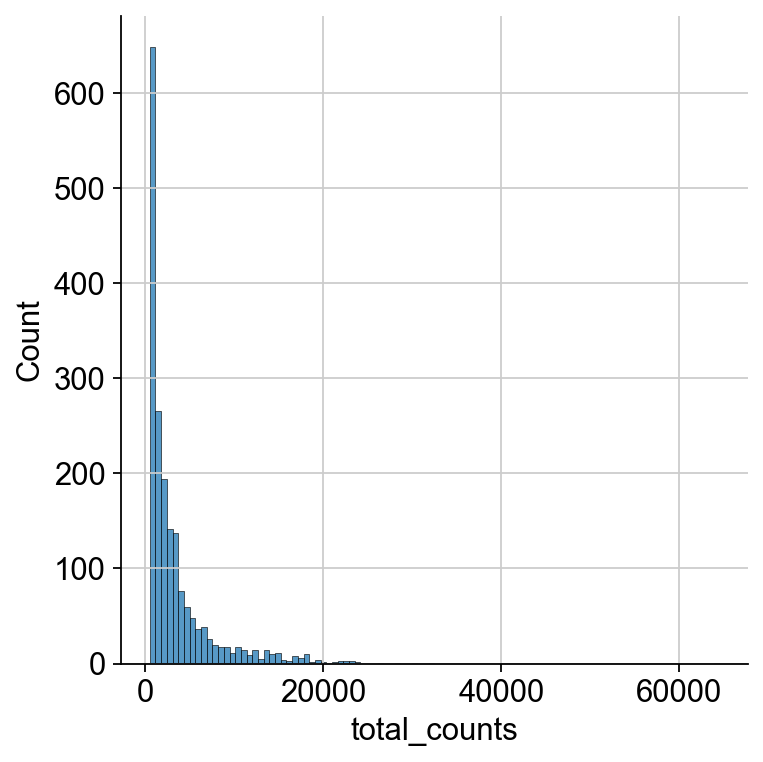

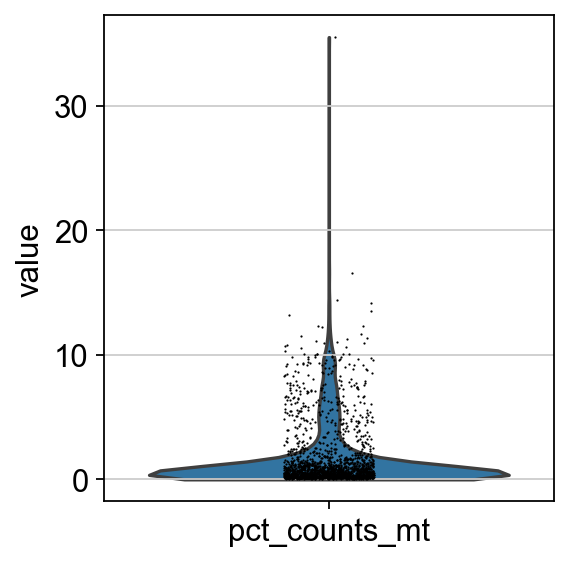

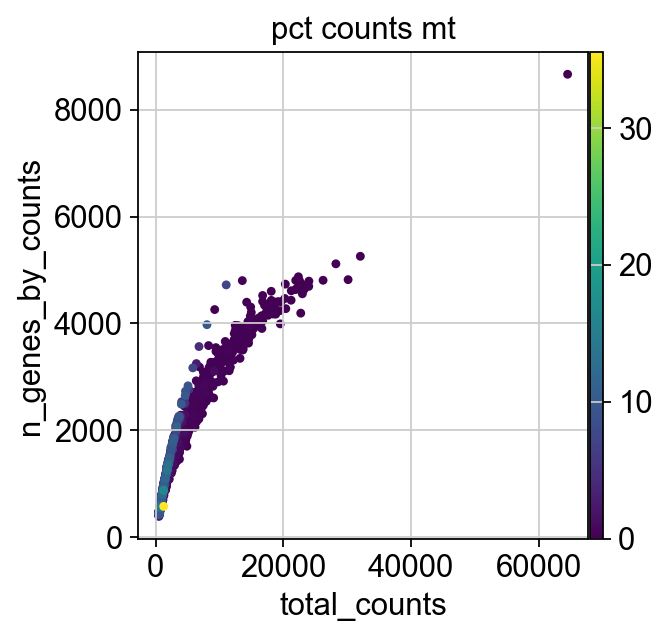

False    1840
True       48
Name: outlier, dtype: int64
False    1681
True      207
Name: mt_outlier, dtype: int64
Total number of cells: 1888
Number of cells after filtering of low quality cells: 1645


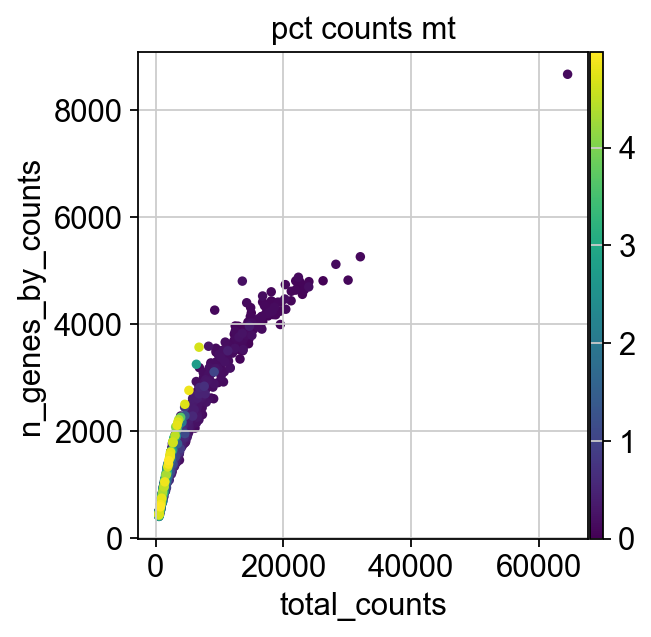

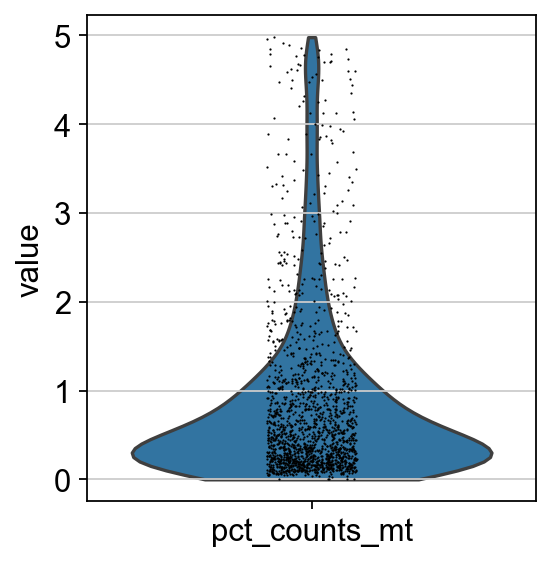

P_CTRL_8W_F_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


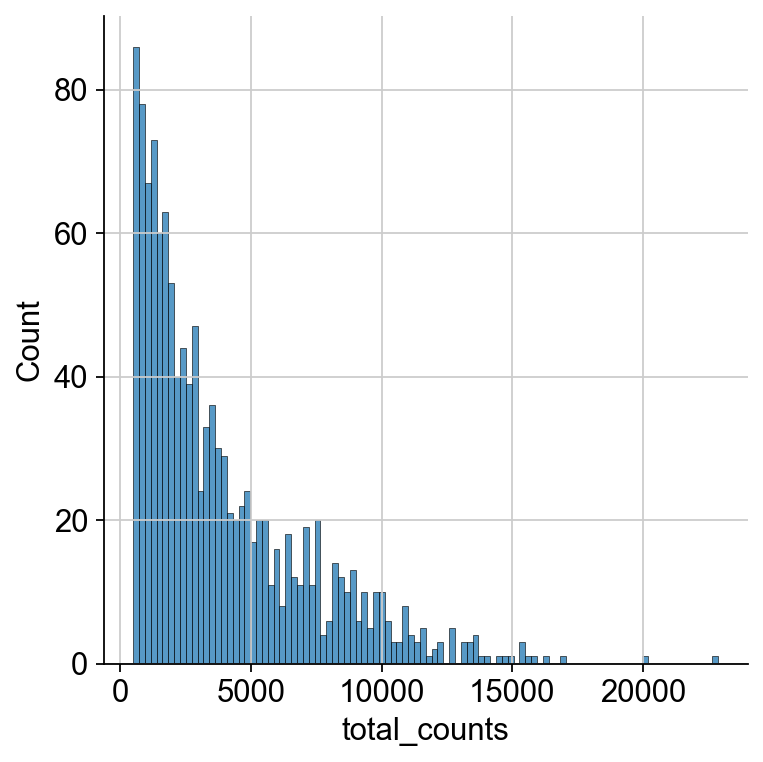

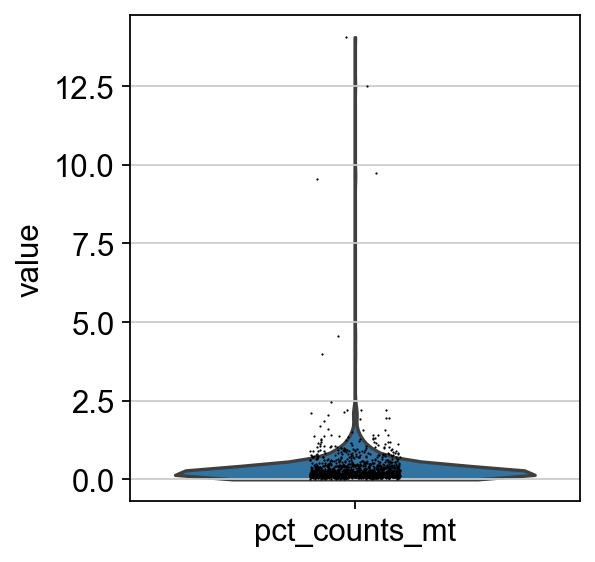

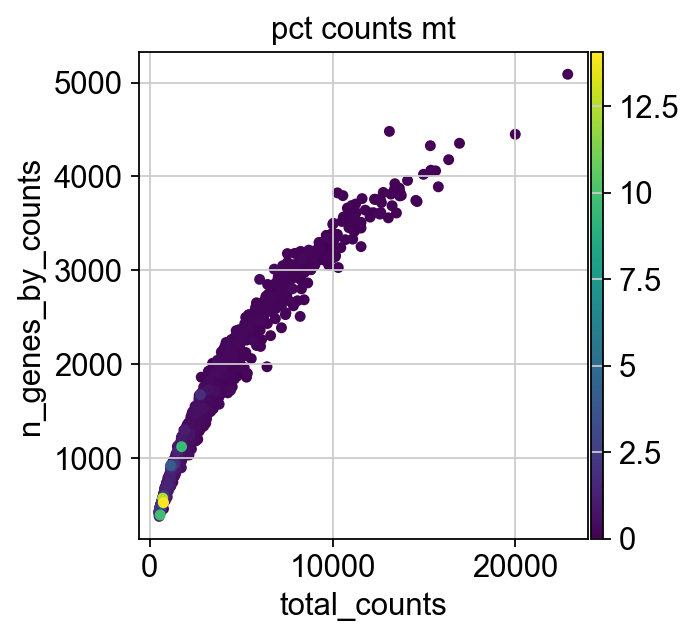

False    1221
True       18
Name: outlier, dtype: int64
False    1235
True        4
Name: mt_outlier, dtype: int64
Total number of cells: 1239
Number of cells after filtering of low quality cells: 1220


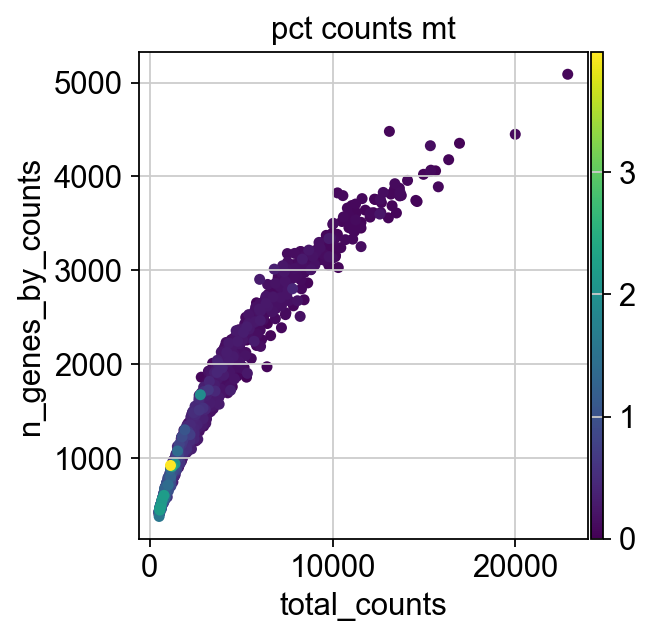

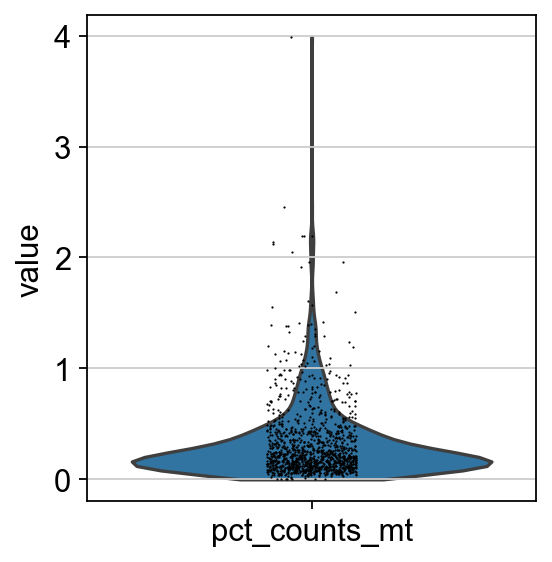

P_CTRL_8W_F_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


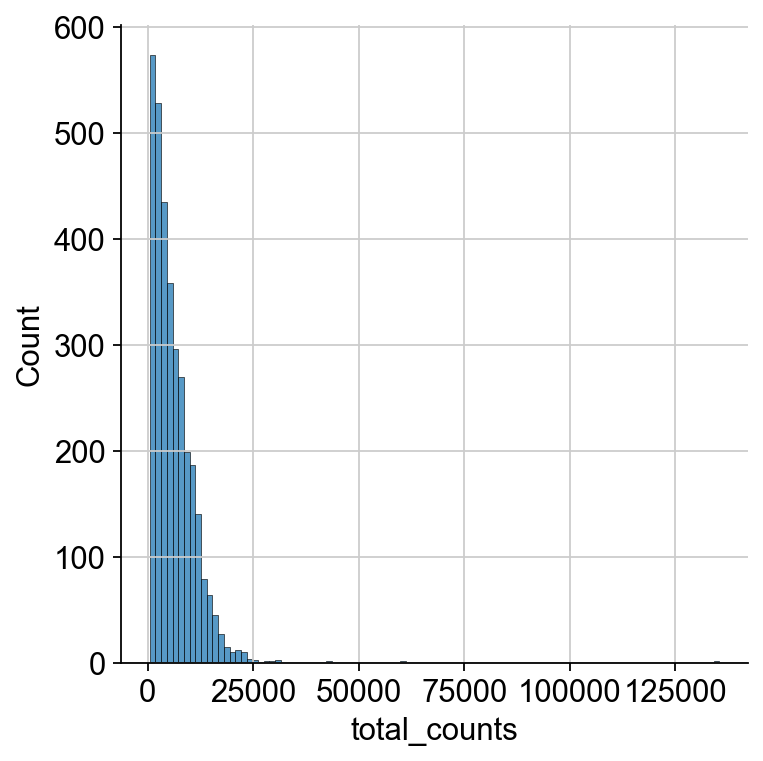

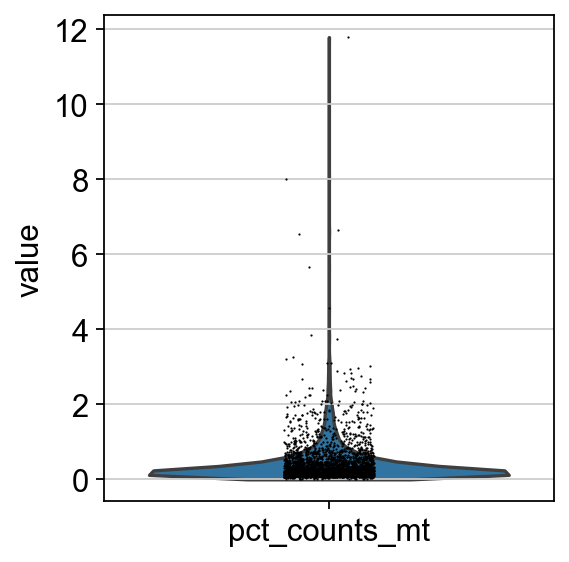

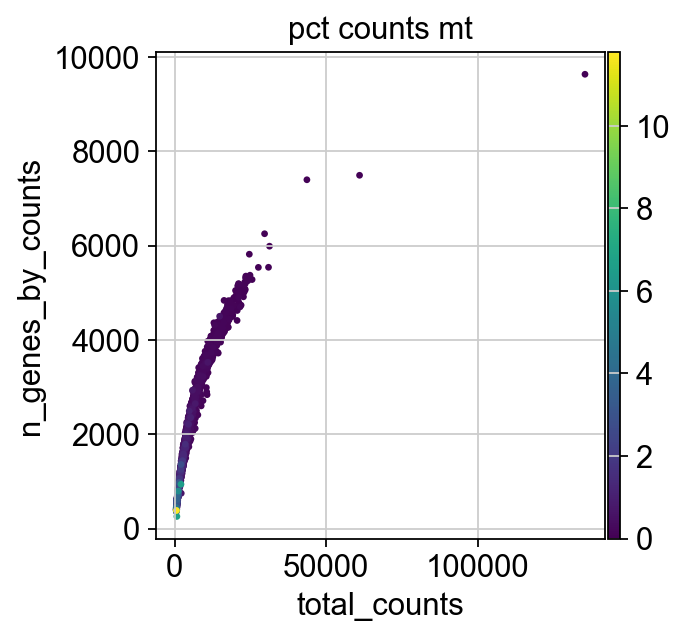

False    3038
True      220
Name: outlier, dtype: int64
False    3253
True        5
Name: mt_outlier, dtype: int64
Total number of cells: 3258
Number of cells after filtering of low quality cells: 3037


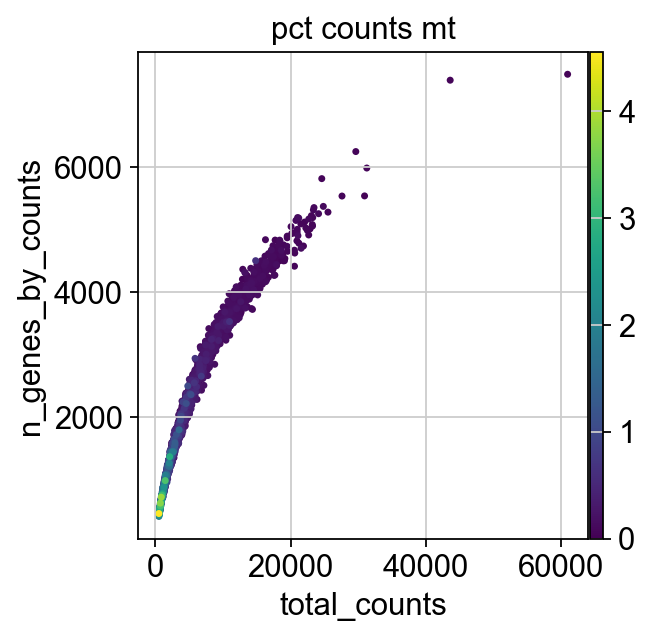

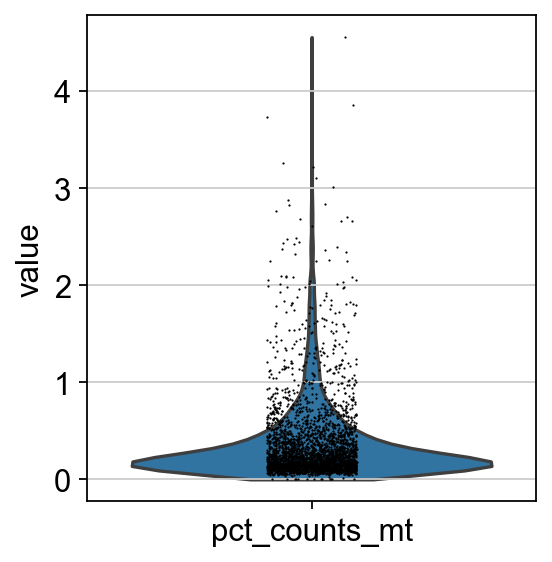

P_HF_24W_F_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


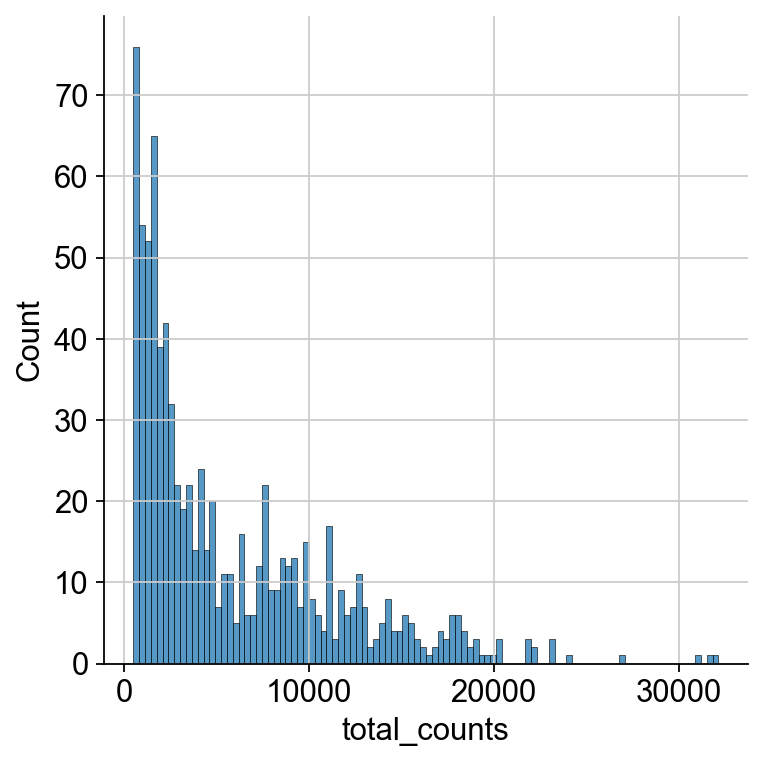

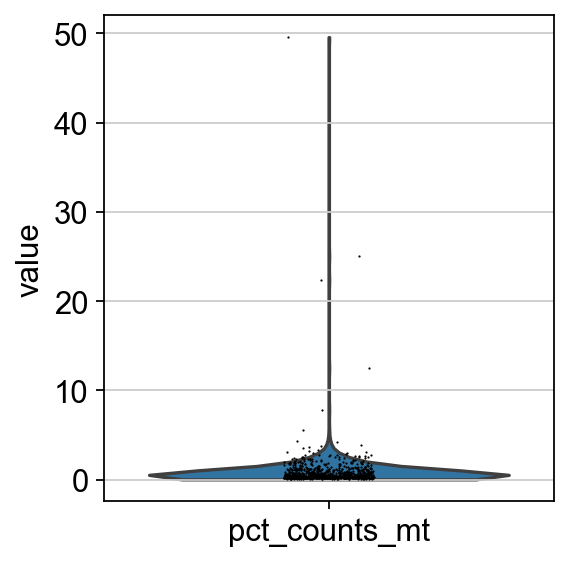

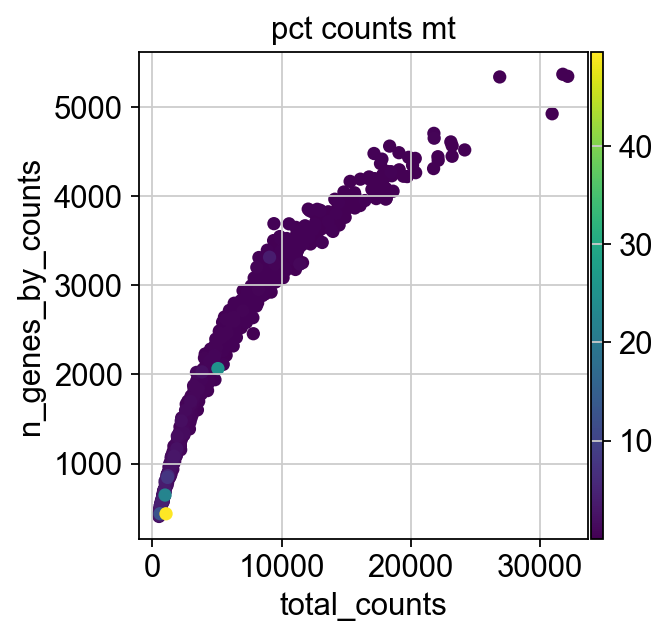

False    820
True      19
Name: outlier, dtype: int64
False    833
True       6
Name: mt_outlier, dtype: int64
Total number of cells: 839
Number of cells after filtering of low quality cells: 818


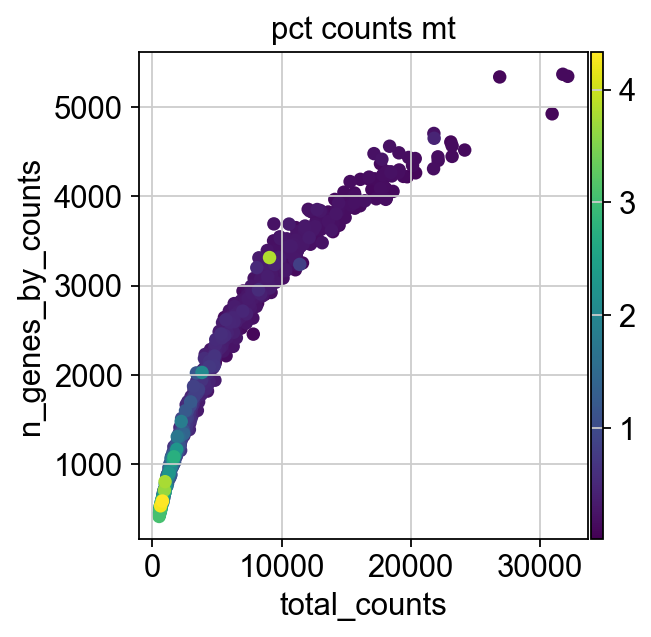

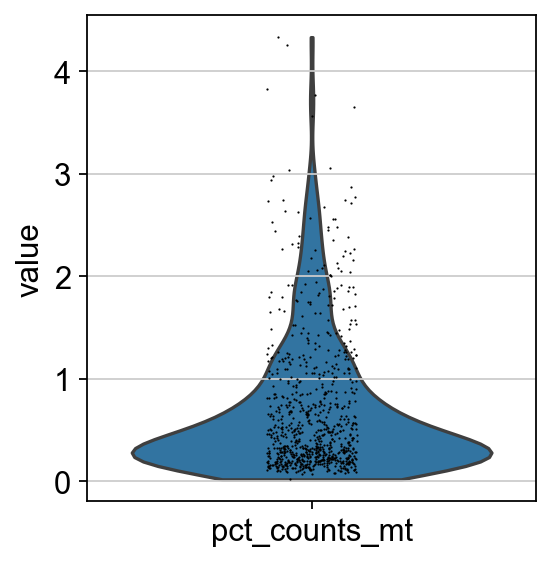

P_HF_24W_F_04


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


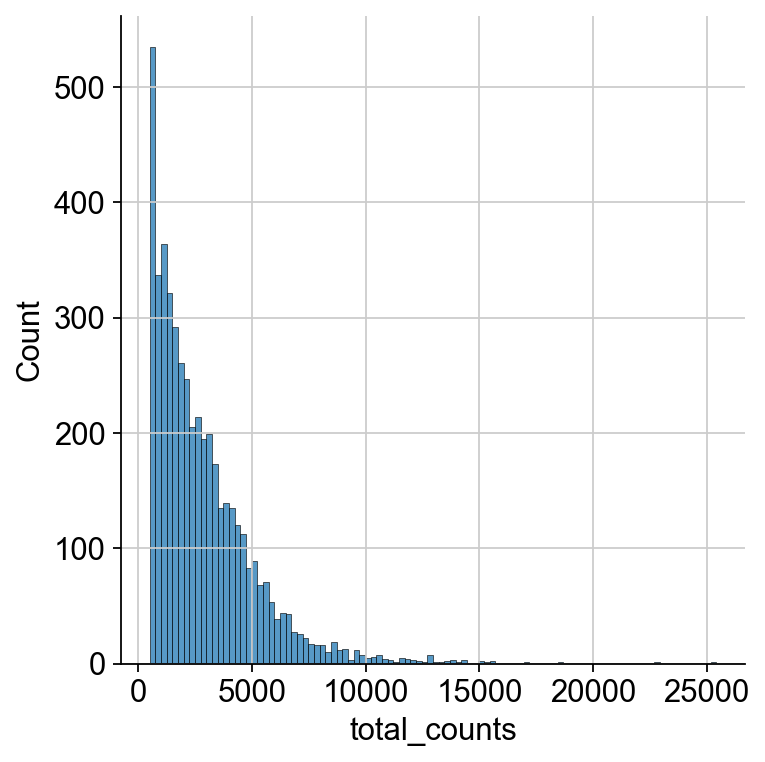

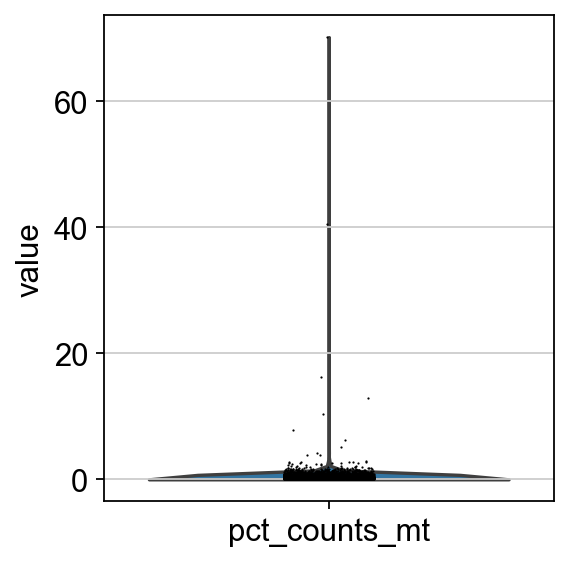

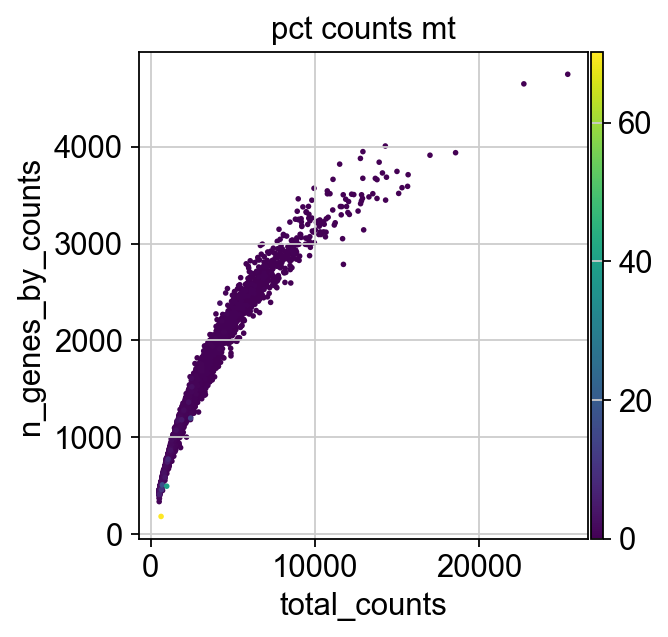

False    4623
True      119
Name: outlier, dtype: int64
False    4734
True        8
Name: mt_outlier, dtype: int64
Total number of cells: 4742
Number of cells after filtering of low quality cells: 4621


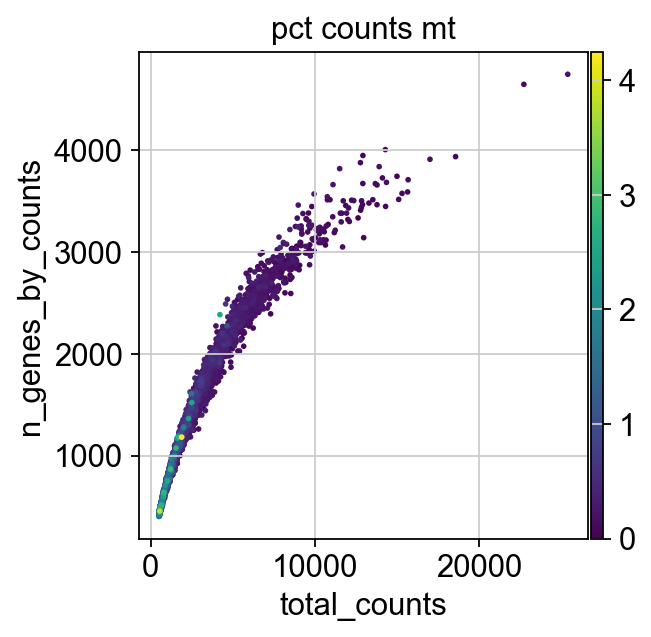

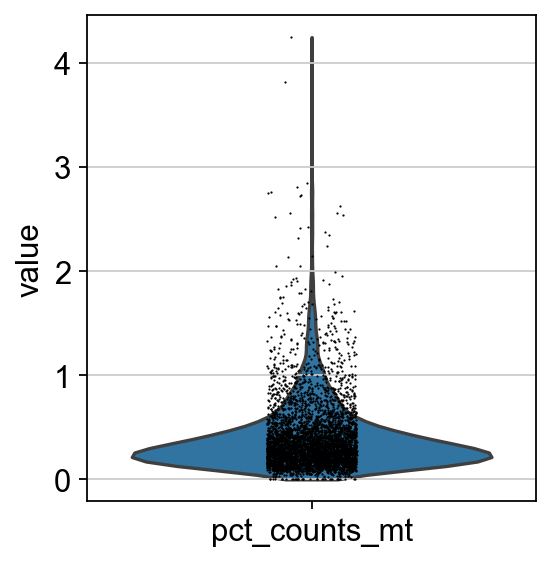

P_HF_8W_F_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


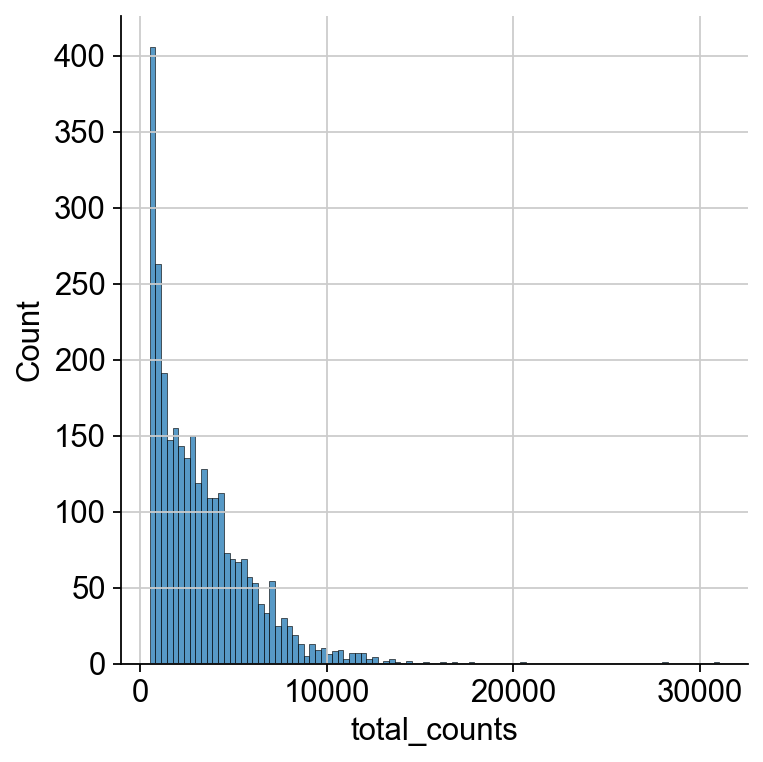

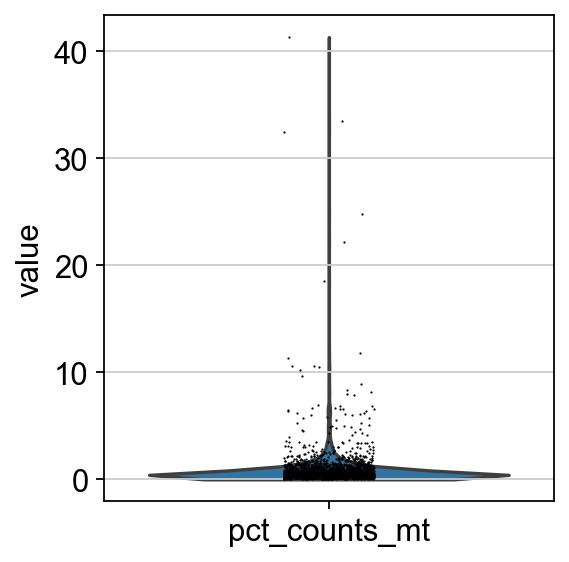

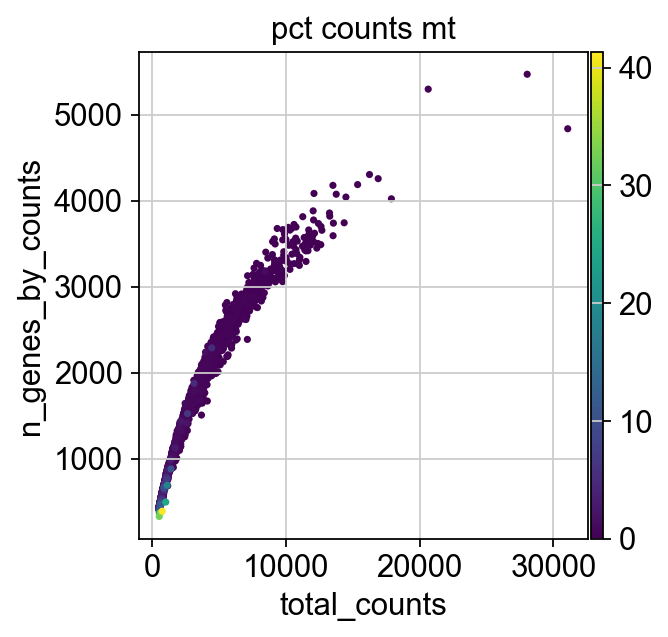

False    2752
True      147
Name: outlier, dtype: int64
False    2857
True       42
Name: mt_outlier, dtype: int64
Total number of cells: 2899
Number of cells after filtering of low quality cells: 2748


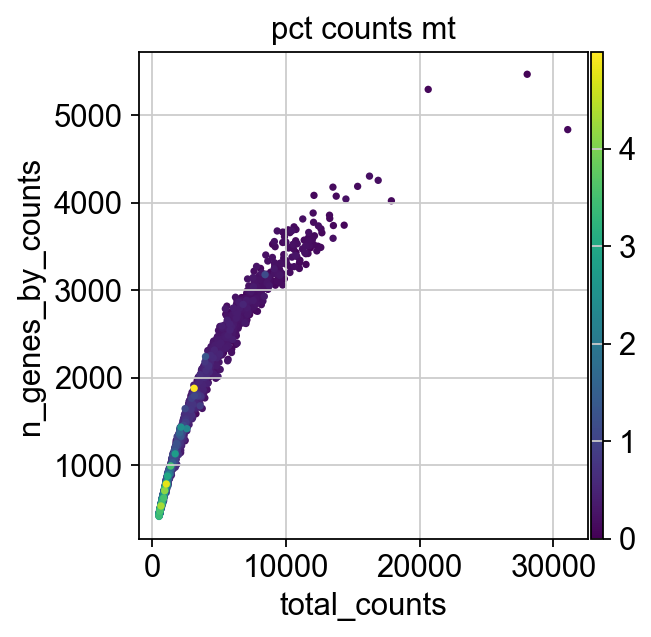

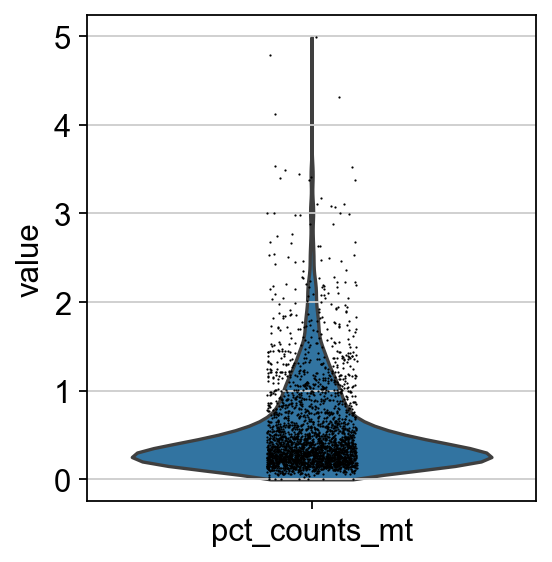

P_CTRL_24W_F_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


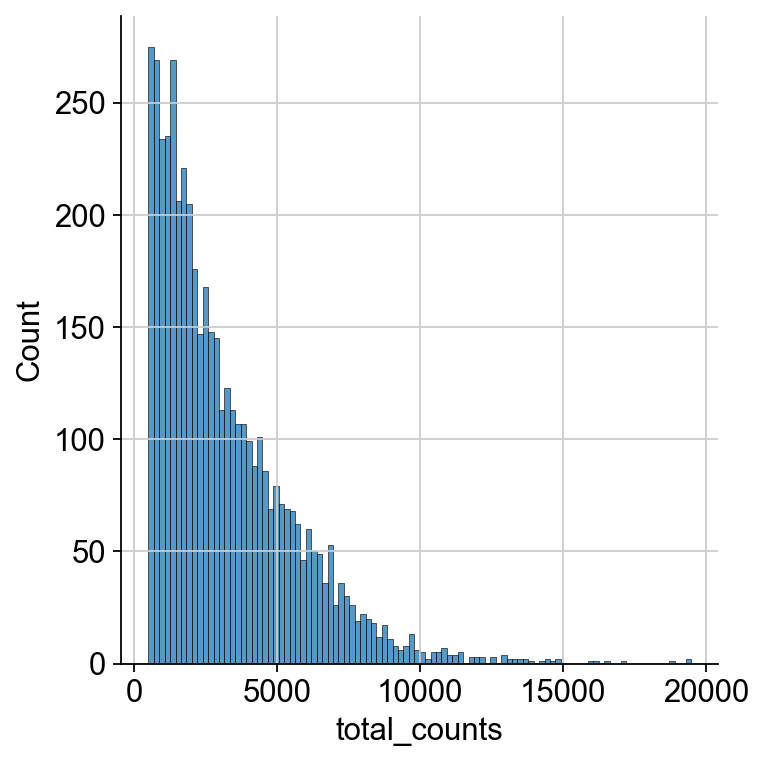

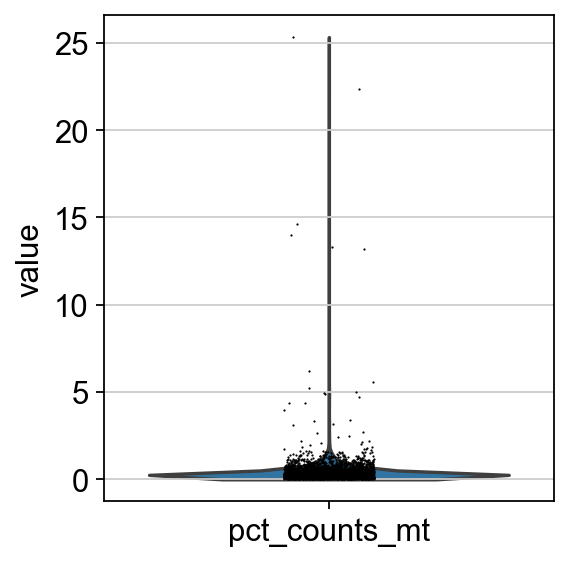

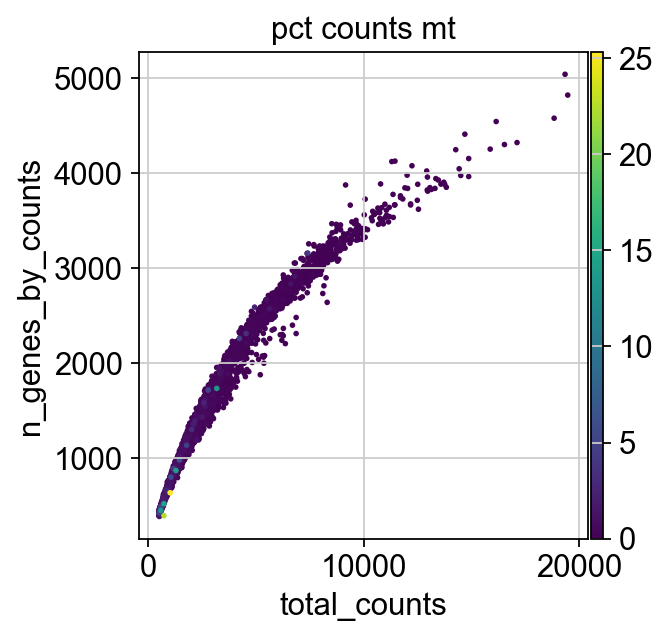

False    4587
True      113
Name: outlier, dtype: int64
False    4691
True        9
Name: mt_outlier, dtype: int64
Total number of cells: 4700
Number of cells after filtering of low quality cells: 4585


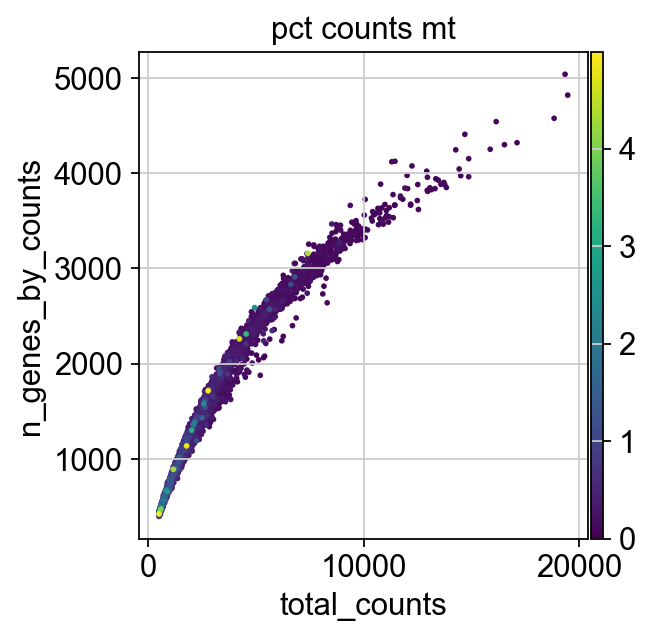

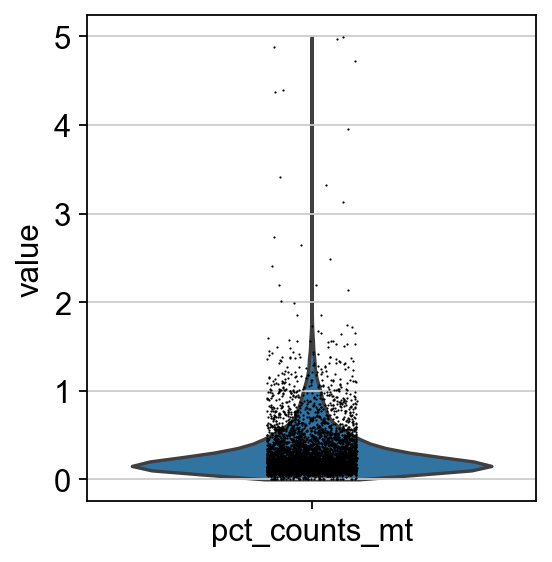

P_CTRL_24W_F_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


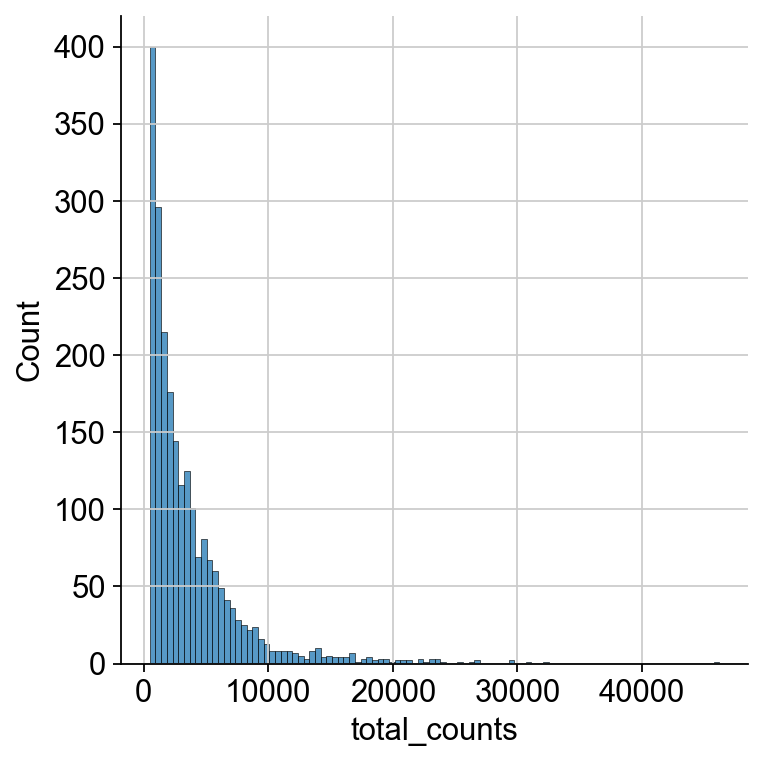

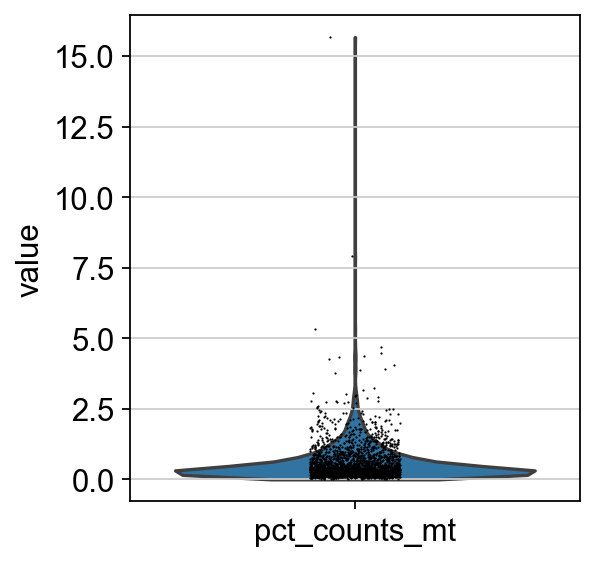

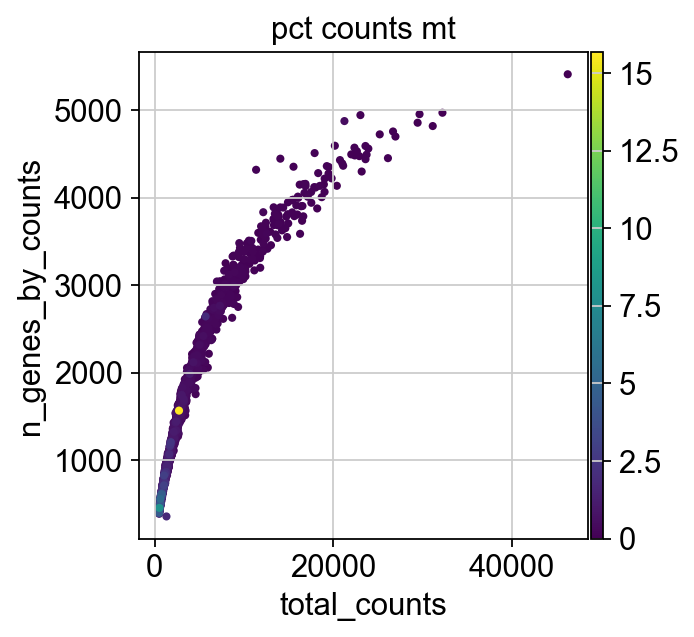

False    2193
True       47
Name: outlier, dtype: int64
False    2237
True        3
Name: mt_outlier, dtype: int64
Total number of cells: 2240
Number of cells after filtering of low quality cells: 2191


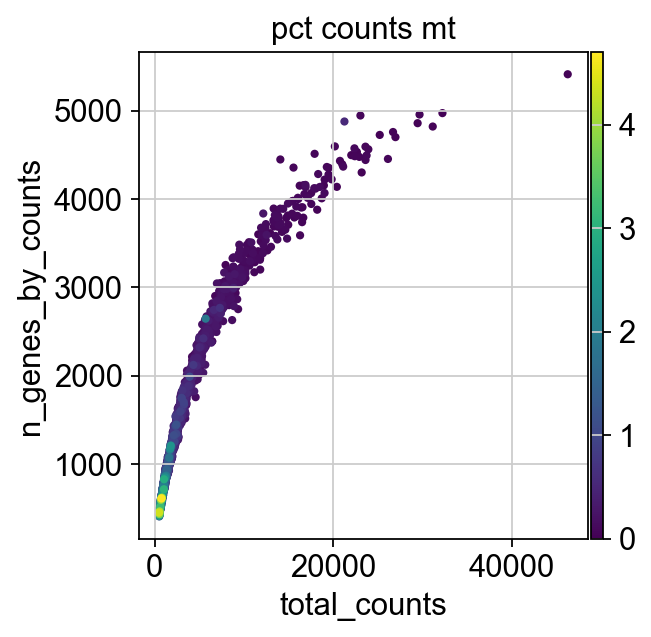

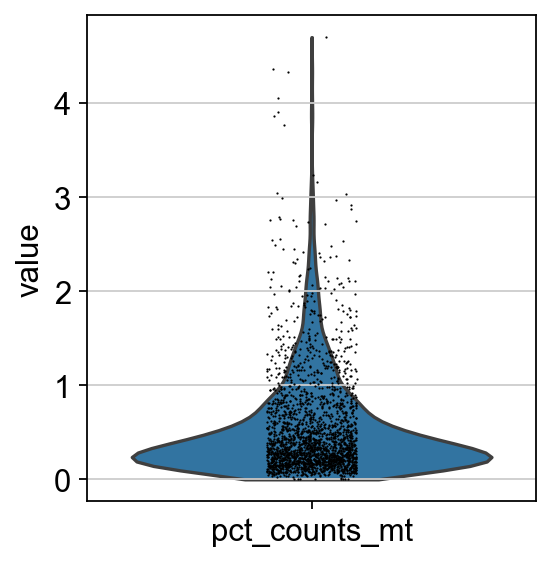

P_CTRL_8W_F_02


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


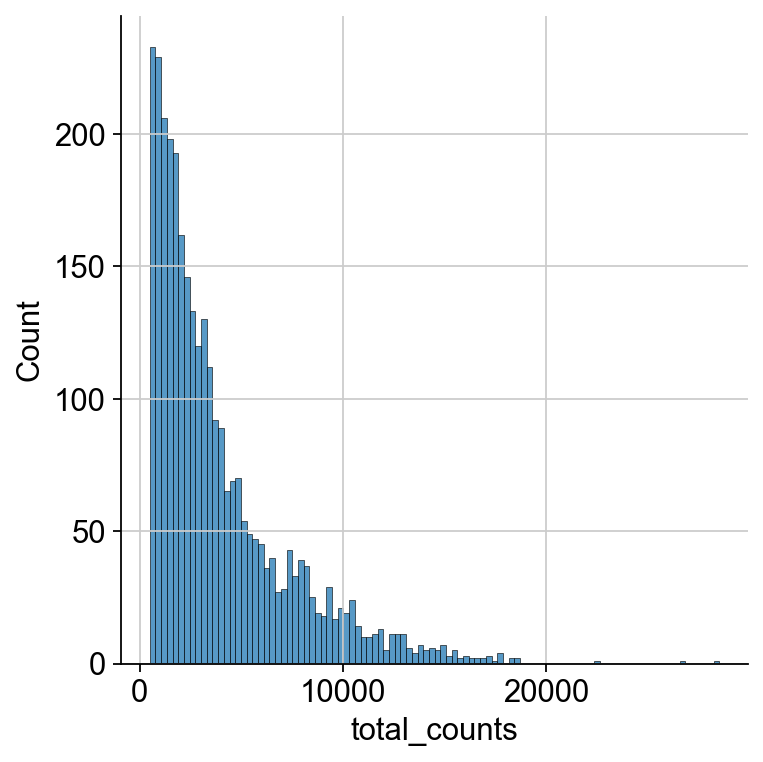

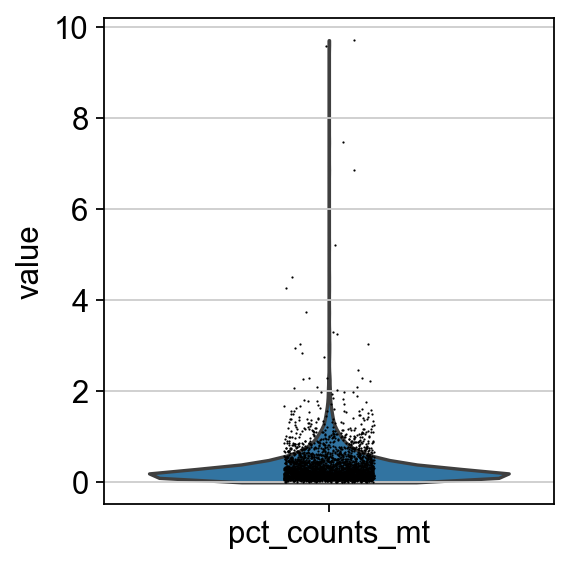

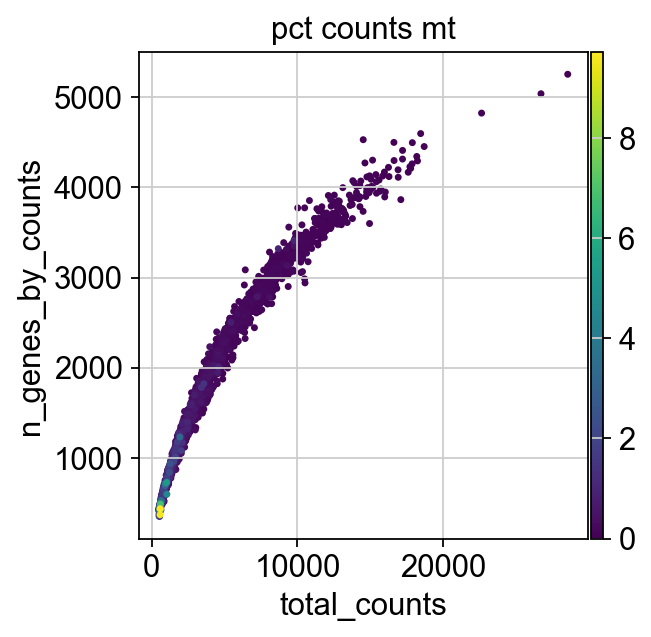

False    2973
True       94
Name: outlier, dtype: int64
False    3062
True        5
Name: mt_outlier, dtype: int64
Total number of cells: 3067
Number of cells after filtering of low quality cells: 2971


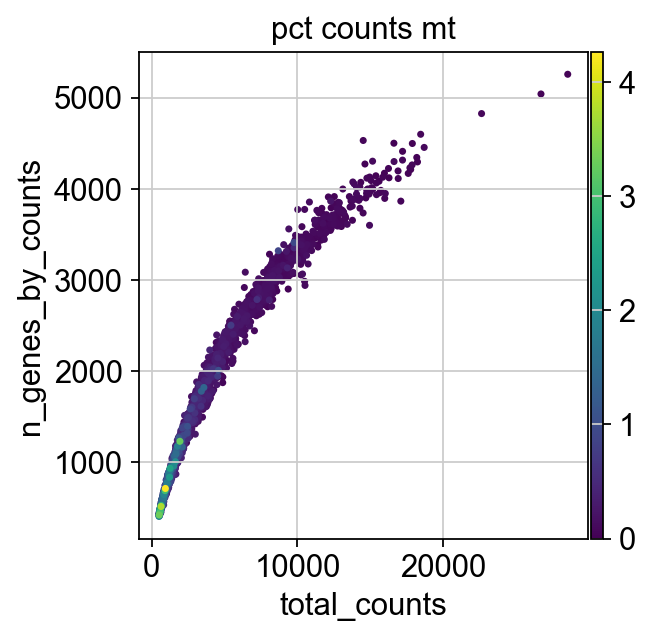

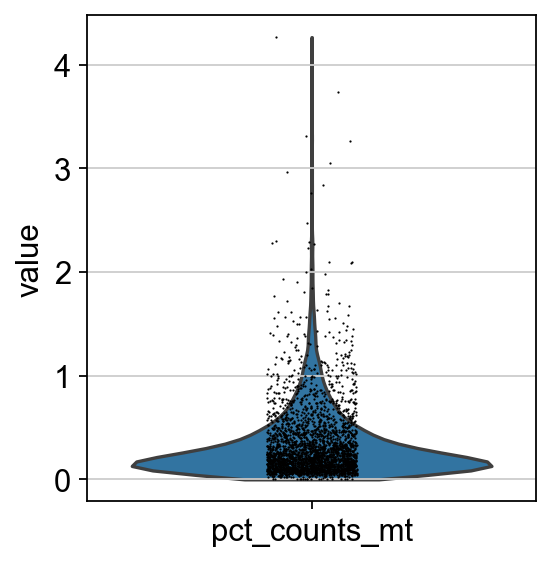

P_HF_24W_F_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


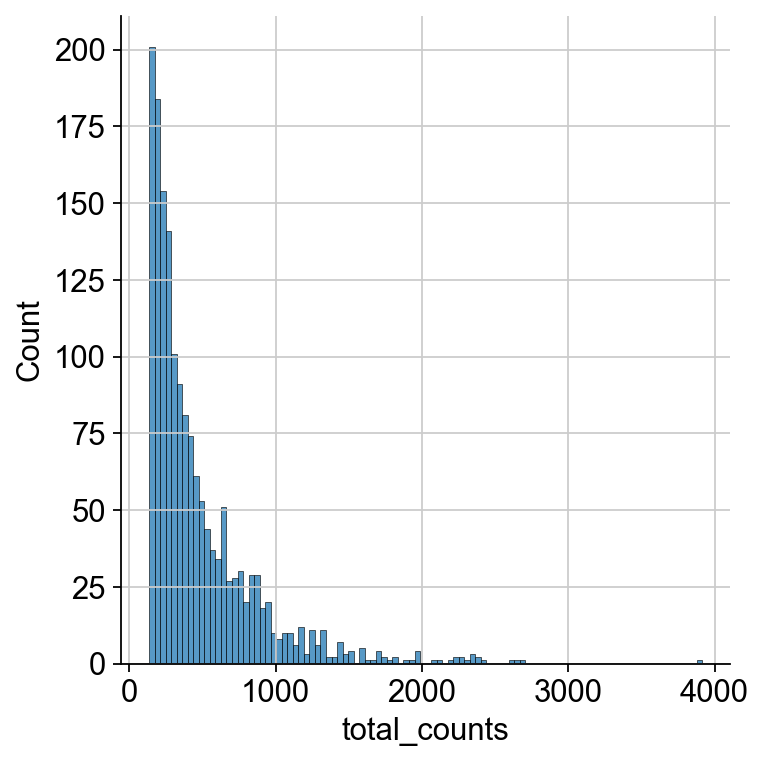

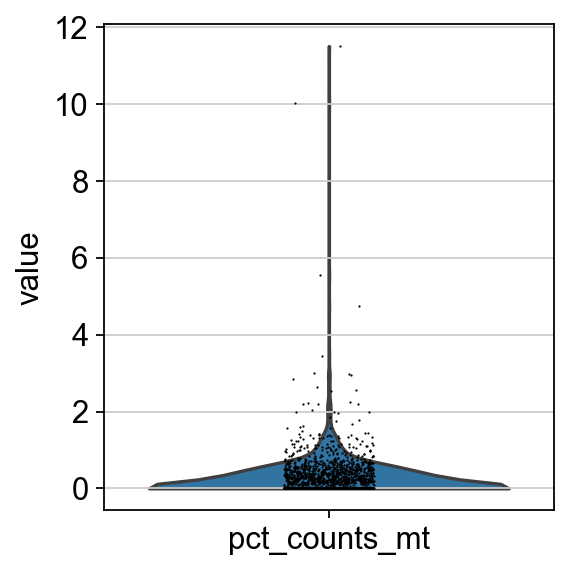

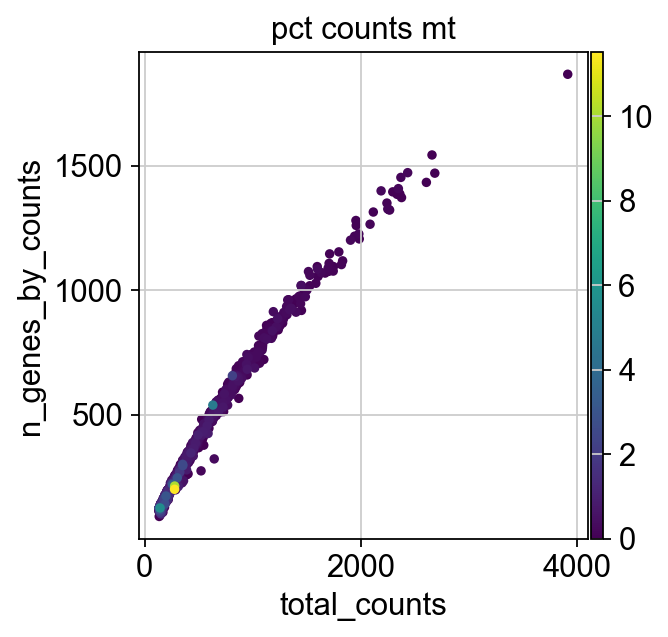

False    1640
True       13
Name: outlier, dtype: int64
False    1650
True        3
Name: mt_outlier, dtype: int64
Total number of cells: 1653
Number of cells after filtering of low quality cells: 1637


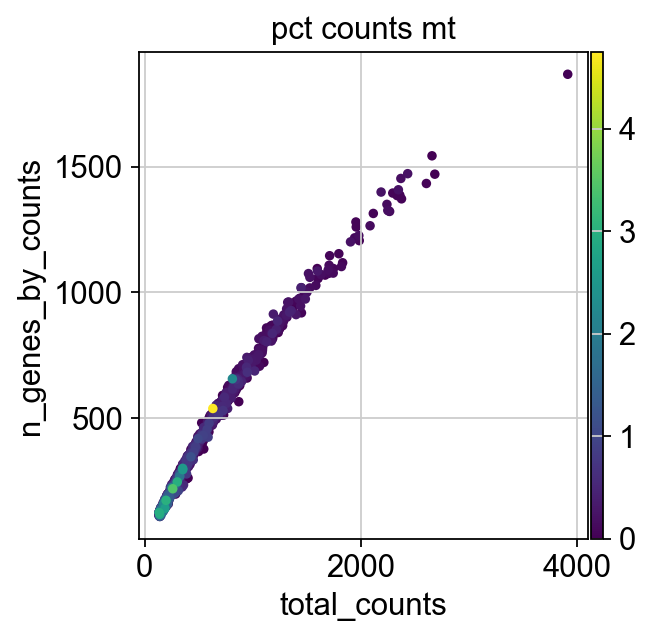

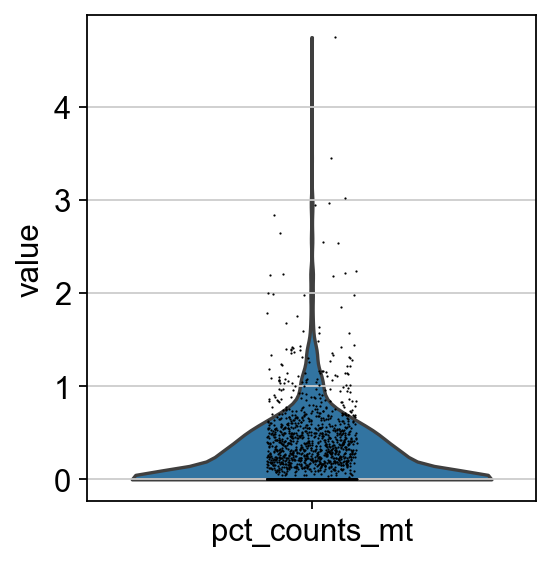

P_HF_24W_F_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


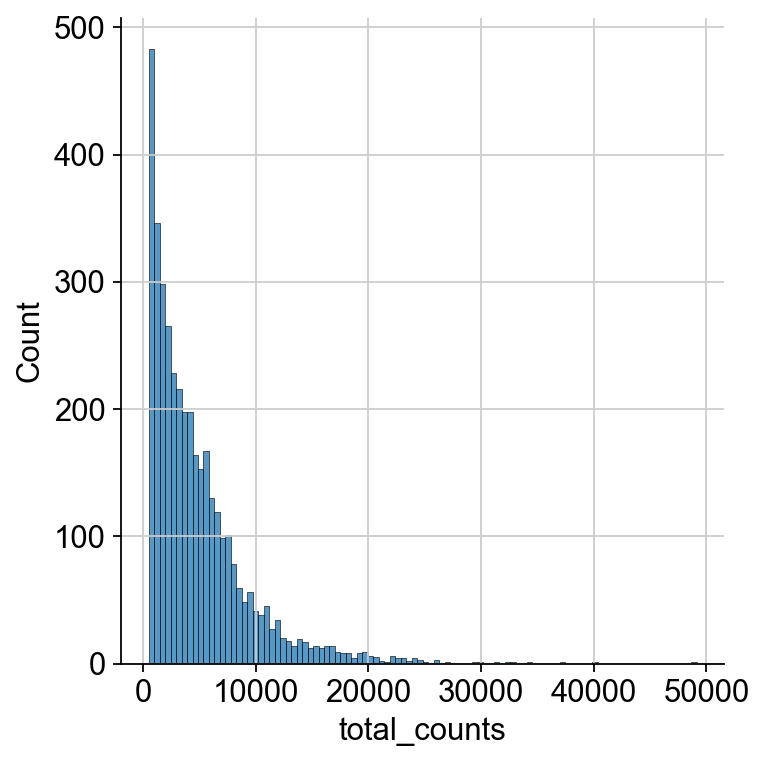

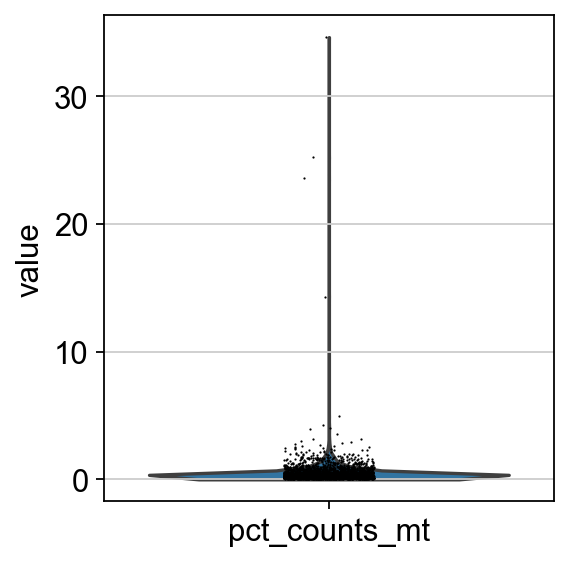

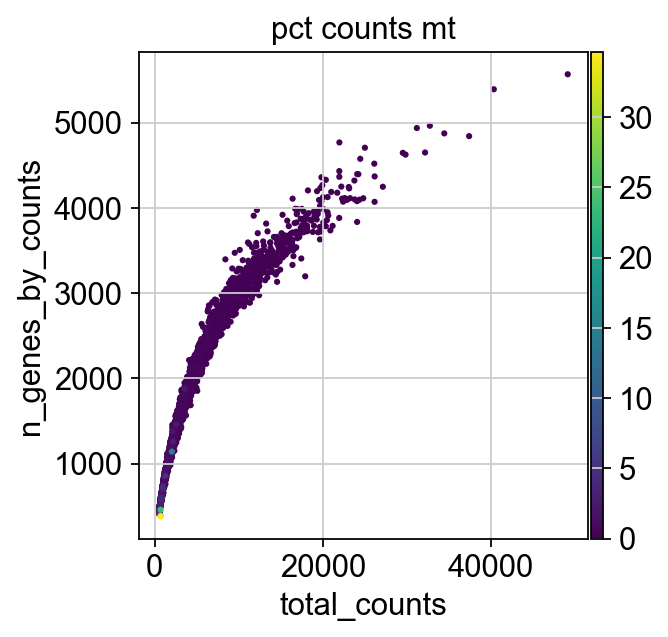

False    3780
True       62
Name: outlier, dtype: int64
False    3838
True        4
Name: mt_outlier, dtype: int64
Total number of cells: 3842
Number of cells after filtering of low quality cells: 3780


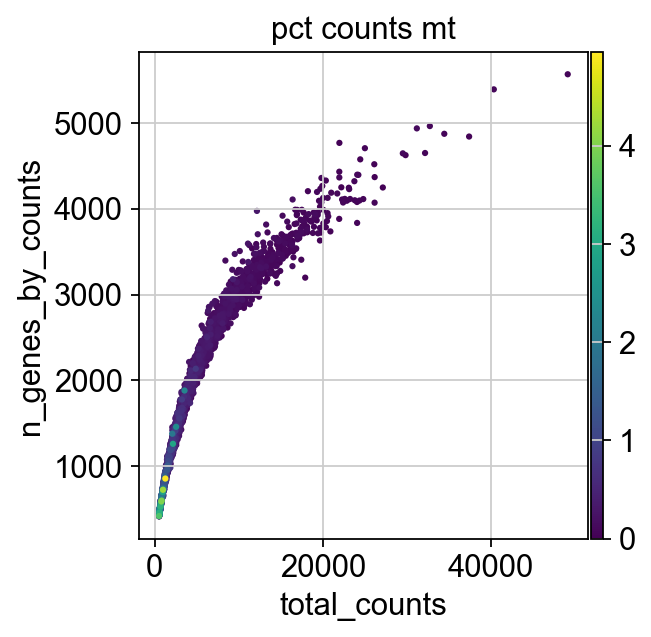

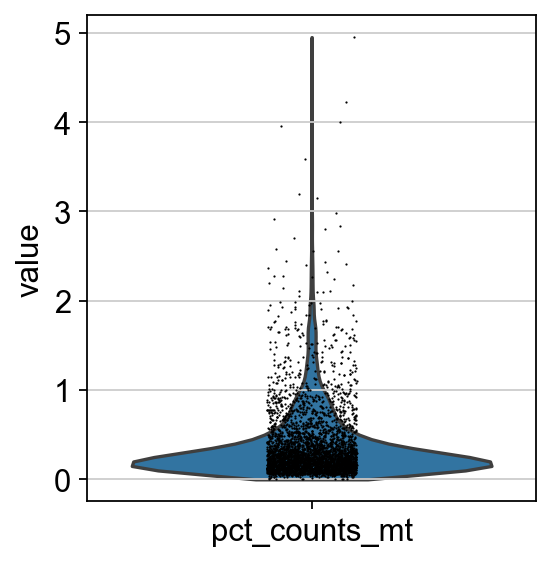

P_HF_8W_F_01


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


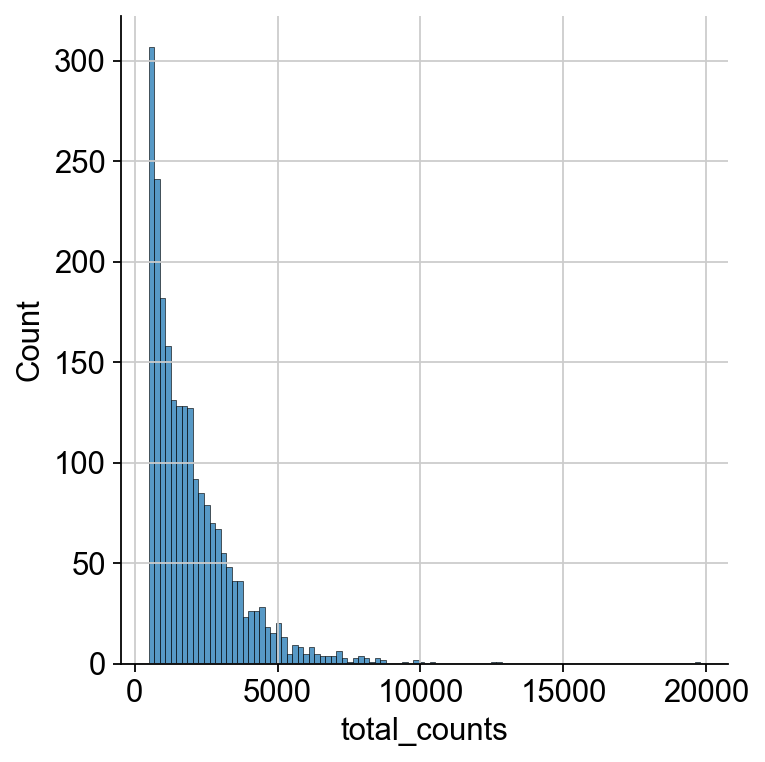

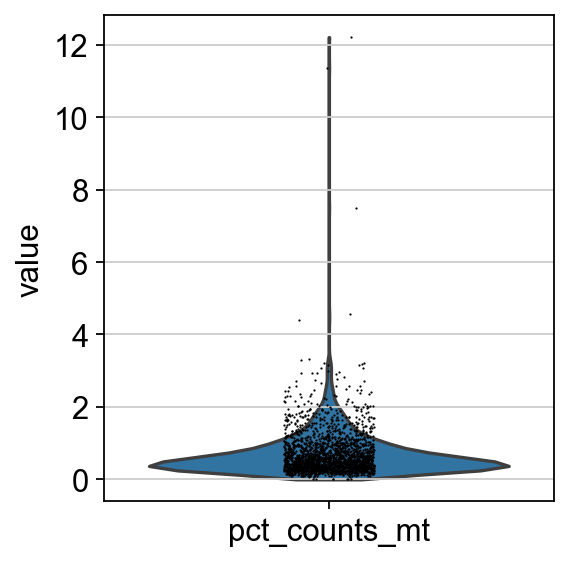

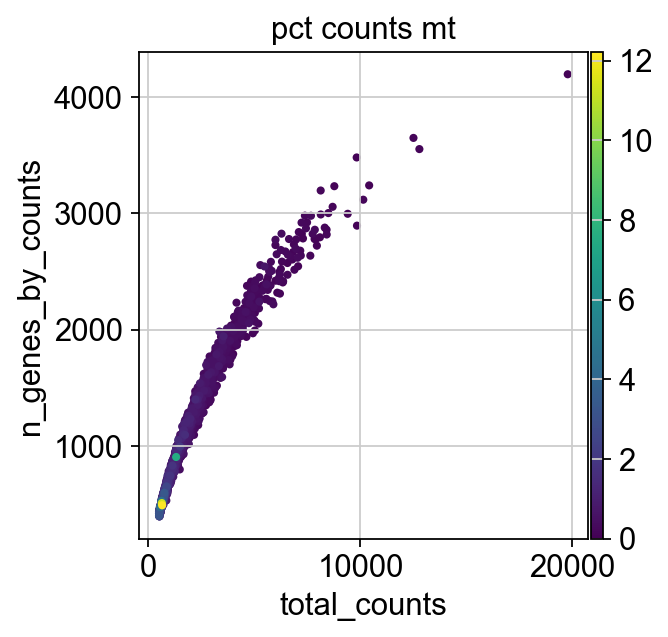

False    2211
True       24
Name: outlier, dtype: int64
False    2232
True        3
Name: mt_outlier, dtype: int64
Total number of cells: 2235
Number of cells after filtering of low quality cells: 2210


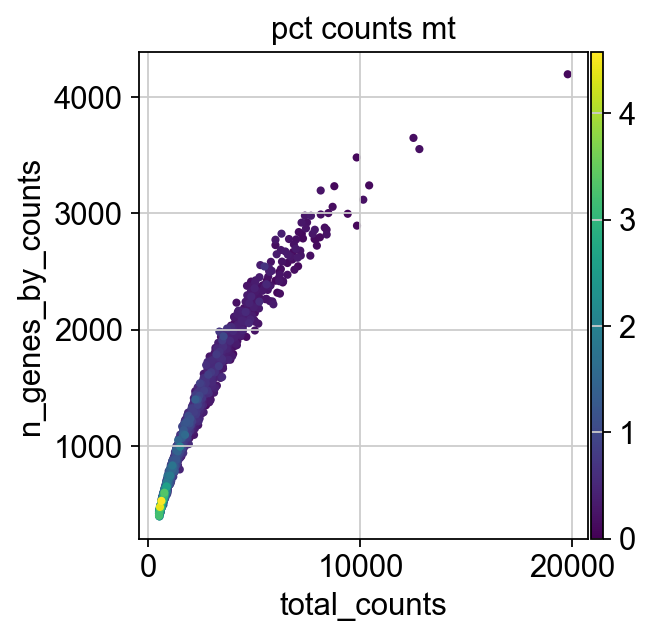

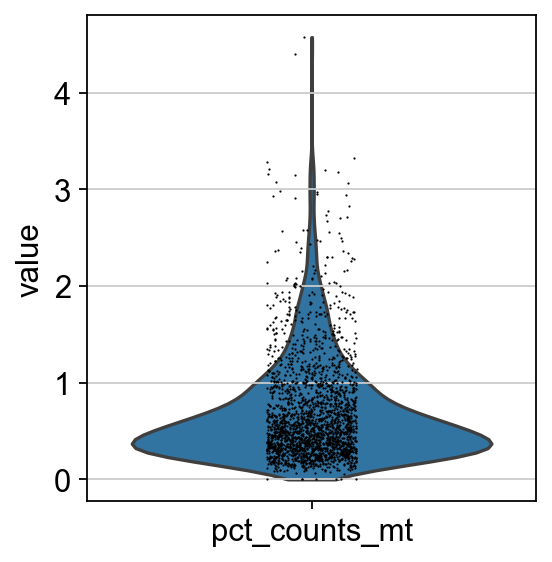

P_HF_8W_F_03


c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


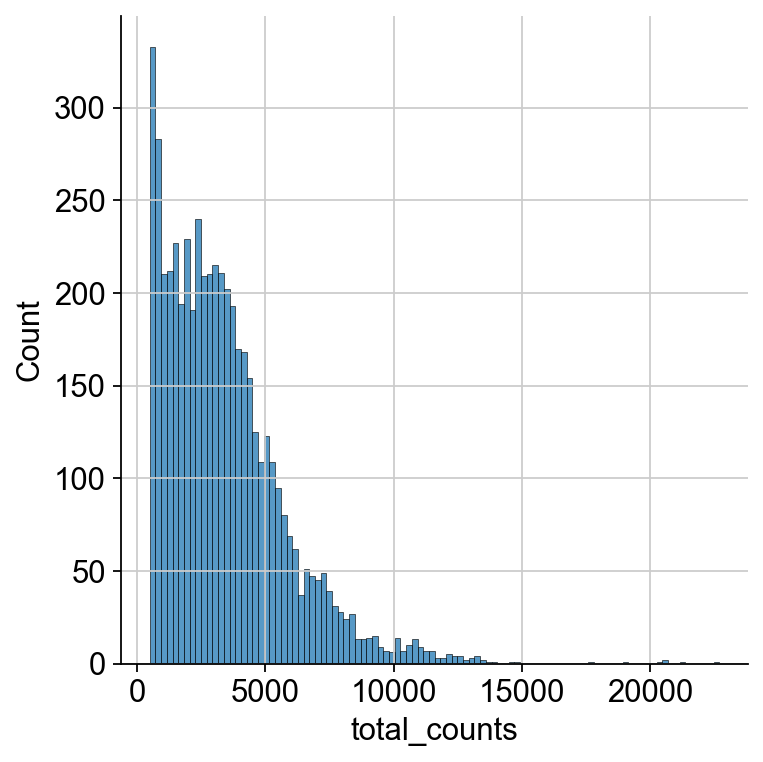

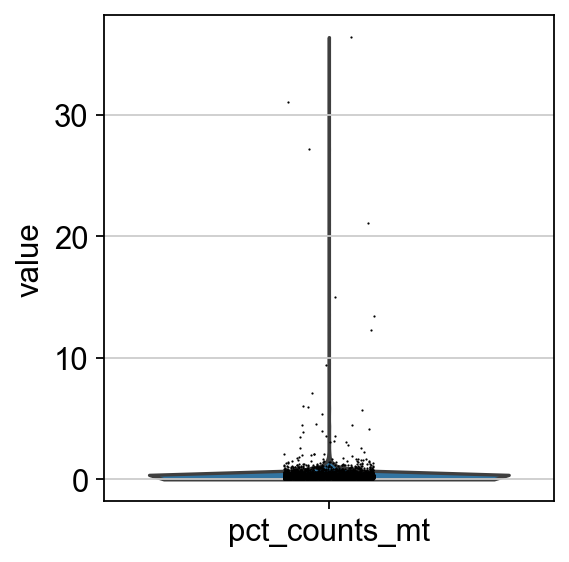

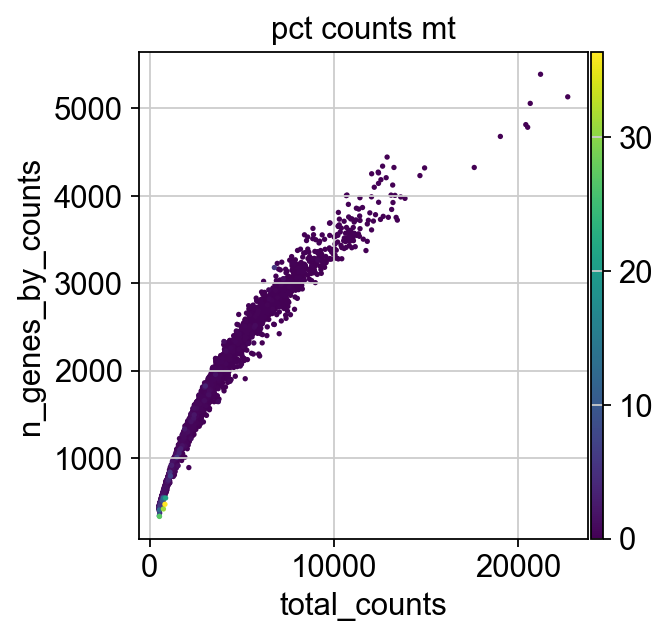

False    5038
True      148
Name: outlier, dtype: int64
False    5173
True       13
Name: mt_outlier, dtype: int64
Total number of cells: 5186
Number of cells after filtering of low quality cells: 5035


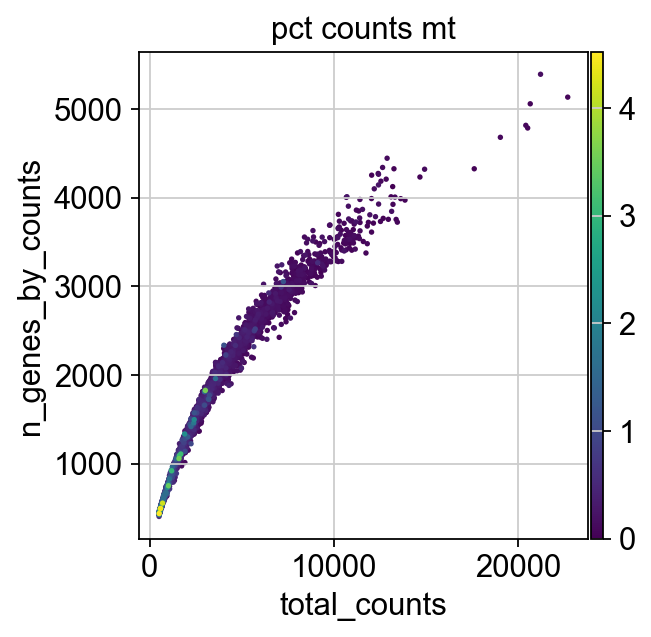

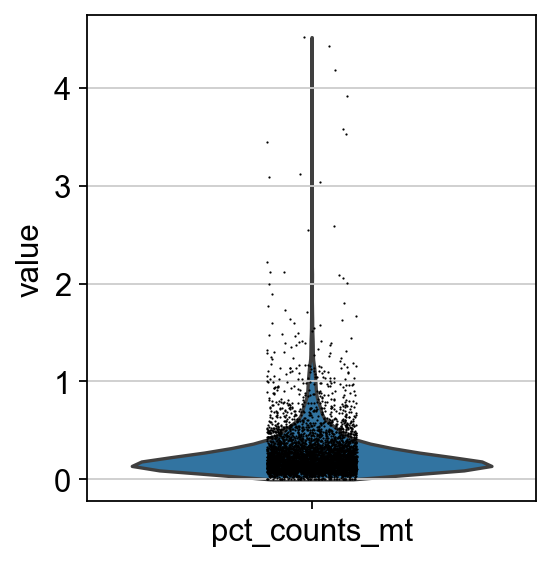

In [8]:
adatas = [pp(adata) for adata in sample_ids]

In [9]:
adatas = [cook_soup(adata) for adata in adatas]

c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Leanovo\anaconda3\envs\soupx2\Lib\site-packages\umap\distances.py:1086: Num

1289 genes passed tf-idf cut-off and 356 soup quantile filter.  Taking the top 100.
Using 820 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 15 clusters to 2361 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1227 genes passed tf-idf cut-off and 149 soup quantile filter.  Taking the top 100.
Using 702 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 15 clusters to 3049 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1383 genes passed tf-idf cut-off and 256 soup quantile filter.  Taking the top 100.
Using 1045 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 17 clusters to 1629 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1151 genes passed tf-idf cut-off and 129 soup quantile filter.  Taking the top 100.
Using 744 independent estimates of rho.
Estimated global rho of 0.07
Expanding counts from 16 clusters to 4111 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1315 genes passed tf-idf cut-off and 218 soup quantile filter.  Taking the top 100.
Using 934 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 16 clusters to 2436 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1001 genes passed tf-idf cut-off and 120 soup quantile filter.  Taking the top 100.
Using 643 independent estimates of rho.
Estimated global rho of 0.04
Expanding counts from 17 clusters to 4162 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


717 genes passed tf-idf cut-off and 159 soup quantile filter.  Taking the top 100.
Using 527 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 12 clusters to 1882 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1285 genes passed tf-idf cut-off and 102 soup quantile filter.  Taking the top 100.
Using 501 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 17 clusters to 6506 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1387 genes passed tf-idf cut-off and 121 soup quantile filter.  Taking the top 100.
Using 660 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 17 clusters to 3935 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


689 genes passed tf-idf cut-off and 146 soup quantile filter.  Taking the top 100.
Using 528 independent estimates of rho.
Estimated global rho of 0.06
Expanding counts from 13 clusters to 4519 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1130 genes passed tf-idf cut-off and 112 soup quantile filter.  Taking the top 100.
Using 585 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 16 clusters to 4244 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


895 genes passed tf-idf cut-off and 109 soup quantile filter.  Taking the top 100.
Using 441 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 15 clusters to 5696 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1167 genes passed tf-idf cut-off and 416 soup quantile filter.  Taking the top 100.
Using 837 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 15 clusters to 1645 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1043 genes passed tf-idf cut-off and 220 soup quantile filter.  Taking the top 100.
Using 658 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 13 clusters to 1220 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


1147 genes passed tf-idf cut-off and 59 soup quantile filter.  Taking the top 59.
Using 322 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 16 clusters to 3037 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


855 genes passed tf-idf cut-off and 60 soup quantile filter.  Taking the top 60.
Using 343 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 12 clusters to 818 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


859 genes passed tf-idf cut-off and 148 soup quantile filter.  Taking the top 100.
Using 573 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 15 clusters to 4621 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


821 genes passed tf-idf cut-off and 61 soup quantile filter.  Taking the top 61.
Using 339 independent estimates of rho.
Estimated global rho of 0.06
Expanding counts from 14 clusters to 2748 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


994 genes passed tf-idf cut-off and 136 soup quantile filter.  Taking the top 100.
Using 536 independent estimates of rho.
Estimated global rho of 0.04
Expanding counts from 15 clusters to 4585 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


812 genes passed tf-idf cut-off and 113 soup quantile filter.  Taking the top 100.
Using 529 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 13 clusters to 2191 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


951 genes passed tf-idf cut-off and 152 soup quantile filter.  Taking the top 100.
Using 625 independent estimates of rho.
Estimated global rho of 0.04
Expanding counts from 15 clusters to 2971 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


148 genes passed tf-idf cut-off and 46 soup quantile filter.  Taking the top 46.
Using 278 independent estimates of rho.
Estimated global rho of 0.10
Expanding counts from 9 clusters to 1637 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


889 genes passed tf-idf cut-off and 102 soup quantile filter.  Taking the top 100.
Using 548 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 16 clusters to 3780 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


813 genes passed tf-idf cut-off and 262 soup quantile filter.  Taking the top 100.
Using 738 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 13 clusters to 2210 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


801 genes passed tf-idf cut-off and 57 soup quantile filter.  Taking the top 57.
Using 230 independent estimates of rho.
Estimated global rho of 0.07
Expanding counts from 14 clusters to 5035 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [10]:
### Print the percent of reads kept after soupX decontamination
for i in range(len(adatas)):
    pct_kept = adatas[i].layers['soupX_counts'].sum()/adatas[i].layers['raw_counts'].sum()
    print('For sample ', i ,'The percent of reads kept is: ', pct_kept * 100)

For sample  0 The percent of reads kept is:  95.38900840891303
For sample  1 The percent of reads kept is:  94.68866791132325
For sample  2 The percent of reads kept is:  98.40469067710814
For sample  3 The percent of reads kept is:  93.39838340251085
For sample  4 The percent of reads kept is:  95.01575078607382
For sample  5 The percent of reads kept is:  96.40385898678898
For sample  6 The percent of reads kept is:  97.40533076852591
For sample  7 The percent of reads kept is:  97.39790596682538
For sample  8 The percent of reads kept is:  97.2954814045389
For sample  9 The percent of reads kept is:  93.70051411950139
For sample  10 The percent of reads kept is:  96.79406287659236
For sample  11 The percent of reads kept is:  96.80324043032385
For sample  12 The percent of reads kept is:  97.8030253149319
For sample  13 The percent of reads kept is:  98.20359767396613
For sample  14 The percent of reads kept is:  96.80106116575082
For sample  15 The percent of reads kept is:  97.699

In [11]:
### Apply minimum cell and gene filters
for adata in adatas:
    print(f"Total number of genes: {adata.n_vars}")
    # Min 1 cells - filters out 0 count genes
    sc.pp.filter_genes(adata, min_cells=1)
    print(f"Number of genes after cell filter: {adata.n_vars}")

    ## Filter cells
    print(f"Total number of cells: {adata.n_obs}")
    sc.pp.filter_cells(adata, min_genes = 100)
    print(f"Number of cells after gene filter: {adata.n_obs}")

Total number of genes: 25629
Number of genes after cell filter: 18870
Total number of cells: 2361
Number of cells after gene filter: 2361
Total number of genes: 25629
Number of genes after cell filter: 18427
Total number of cells: 3049
Number of cells after gene filter: 3049
Total number of genes: 25629
Number of genes after cell filter: 18044
Total number of cells: 1629
Number of cells after gene filter: 1629
Total number of genes: 25629
Number of genes after cell filter: 18567
Total number of cells: 4111
Number of cells after gene filter: 4111
Total number of genes: 25629
Number of genes after cell filter: 18373
Total number of cells: 2436
Number of cells after gene filter: 2436
Total number of genes: 25629
Number of genes after cell filter: 18941
Total number of cells: 4162
Number of cells after gene filter: 4162
Total number of genes: 25629
Number of genes after cell filter: 17431
Total number of cells: 1882
Number of cells after gene filter: 1882
Total number of genes: 25629
Numbe

In [12]:
### Run this if you want to save the data before moving on to doublet detection
# i = 0
# for sample_name in sample_ids:
#     adatas[i].write("../data/" + sample_name + "/" + sample_name + "_soupx.h5ad")
#     i+=1

## Doublet Detection

In [13]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

dbl_finder <- function(data_mat){
    set.seed(123)
    sce = scDblFinder(
        SingleCellExperiment(
            list(counts=data_mat),
        ) 
    )
    doublet_score = sce$scDblFinder.score
    doublet_class = sce$scDblFinder.class
    return (c(doublet_score, doublet_class))
}

Attaching SeuratObject
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [14]:
def doublet_removal(adata):
    
    data_mat = adata.X.T

    # Execute the R code and get the corrected counts
    %R -i data_mat -o out out = dbl_finder(data_mat)

    half = int(0.5 * len(out))
    doublet_score = out[:half]
    doublet_class = out[half:]
    doublet_class = doublet_class.astype(str)
    doublet_class[doublet_class == '1.0'] = 'singlet'
    doublet_class[doublet_class == '2.0'] = 'doublet'
    
    ### Creates two columns in adata.obs to store scDblFinder data
    adata.obs["scDblFinder_score"] = doublet_score
    adata.obs["scDblFinder_class"] = doublet_class
    adata.obs.scDblFinder_class.value_counts()
    
    return adata

In [15]:
### Runs scDblFinder. Note that this only labels cells as singlets or doublets, it does not automatically remove them from the adata objects.
adatas = [doublet_removal(adata) for adata in adatas]

Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 390 cells excluded from training.
iter=1, 380 cells excluded from training.
iter=2, 389 cells excluded from training.
Threshold found:0.617
126 (5.3%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 460 cells excluded from training.
iter=1, 422 cells excluded from training.
iter=2, 412 cells excluded from training.
Threshold found:0.578
190 (6.2%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 232 cells excluded from training.
iter=1, 225 cells excluded from training.
iter=2, 212 cells excluded from training.
Threshold found:0.801
79 (4.8%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 631 cells excluded from training.
iter=1, 663 cells excluded from training.
iter=2, 630 cells excluded from training.
Threshold found:0.45
296 (7.2%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 260 cells excluded from training.
iter=1, 264 cells excluded from training.
iter=2, 256 cells excluded from training.
Threshold found:0.626
143 (5.9%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 706 cells excluded from training.
iter=1, 690 cells excluded from training.
iter=2, 667 cells excluded from training.
Threshold found:0.5
212 (5.1%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 256 cells excluded from training.
iter=1, 251 cells excluded from training.
iter=2, 250 cells excluded from training.
Threshold found:0.553
79 (4.2%) doublets called


Creating ~5205 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 858 cells excluded from training.
iter=1, 964 cells excluded from training.
iter=2, 1001 cells excluded from training.
Threshold found:0.436
428 (6.6%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 585 cells excluded from training.
iter=1, 615 cells excluded from training.
iter=2, 629 cells excluded from training.
Threshold found:0.425
255 (6.5%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 644 cells excluded from training.
iter=1, 631 cells excluded from training.
iter=2, 635 cells excluded from training.
Threshold found:0.468
255 (5.6%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 560 cells excluded from training.
iter=1, 567 cells excluded from training.
iter=2, 569 cells excluded from training.
Threshold found:0.416
245 (5.8%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 913 cells excluded from training.
iter=1, 921 cells excluded from training.
iter=2, 929 cells excluded from training.
Threshold found:0.381
354 (6.2%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 199 cells excluded from training.
iter=1, 208 cells excluded from training.
iter=2, 236 cells excluded from training.
Threshold found:0.84
97 (5.9%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 136 cells excluded from training.
iter=1, 147 cells excluded from training.
iter=2, 140 cells excluded from training.
Threshold found:0.764
64 (5.2%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 432 cells excluded from training.
iter=1, 475 cells excluded from training.
iter=2, 496 cells excluded from training.
Threshold found:0.709
198 (6.5%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 69 cells excluded from training.
iter=1, 67 cells excluded from training.
iter=2, 56 cells excluded from training.
Threshold found:0.763
96 (11.7%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 790 cells excluded from training.
iter=1, 799 cells excluded from training.
iter=2, 801 cells excluded from training.
Threshold found:0.487
297 (6.4%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 325 cells excluded from training.
iter=1, 297 cells excluded from training.
iter=2, 304 cells excluded from training.
Threshold found:0.67
164 (6%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 712 cells excluded from training.
iter=1, 713 cells excluded from training.
iter=2, 695 cells excluded from training.
Threshold found:0.442
279 (6.1%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 246 cells excluded from training.
iter=1, 255 cells excluded from training.
iter=2, 265 cells excluded from training.
Threshold found:0.697
120 (5.5%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 420 cells excluded from training.
iter=1, 436 cells excluded from training.
iter=2, 435 cells excluded from training.
Threshold found:0.515
186 (6.3%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 84 cells excluded from training.
iter=1, 92 cells excluded from training.
iter=2, 86 cells excluded from training.
Threshold found:0.774
76 (4.6%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 533 cells excluded from training.
iter=1, 538 cells excluded from training.
iter=2, 541 cells excluded from training.
Threshold found:0.493
239 (6.3%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 334 cells excluded from training.
iter=1, 321 cells excluded from training.
iter=2, 322 cells excluded from training.
Threshold found:0.573
118 (5.3%) doublets called


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 967 cells excluded from training.
iter=1, 1001 cells excluded from training.
iter=2, 994 cells excluded from training.
Threshold found:0.463
375 (7.4%) doublets called


In [16]:
### Save the soupx/scdblfinder preprocessed data

i = 0
for sample_id in sample_ids:
    adatas[i].write("../data/" + sample_id + "_preprocessed.h5ad")
    i+=1